In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn

#### Function

In [168]:
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import clone_model


def split_data(df, target_column, target_series='all', split_type='random', test_size=0.2, group_column=None, n_splits=3):
    """
    Split data using different techniques.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - target_column (str): The name of the target column.
    - split_type (str): The splitting strategy ('random', 'group_kfold', 'stratified_group_kfold').
    - test_size (float): The proportion of the dataset to include in the test split (for random split).
    - group_column (str): Column name to define groups (required for group-based splits).
    - n_splits (int): Number of splits for K-Fold.

    Returns:
    - X_train, X_test, y_train, y_test: Training and testing sets for features and targets.
    """

    # if len(target_series) == 0:
    if target_series == 'all':
        X = df.iloc[:, :-2]
    else:
        X = df[target_series]
    y = df[target_column]

    if split_type == 'random':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    elif split_type == 'group_kfold':
        if group_column is None:
            raise ValueError("group_column must be provided for group_kfold splitting.")
        gkf = GroupKFold(n_splits=n_splits)
        groups = df[group_column]
        train_idx, test_idx = next(gkf.split(X, y, groups=groups))
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    elif split_type == 'stratified_group_kfold':
        if group_column is None:
            raise ValueError("group_column must be provided for stratified_group_kfold splitting.")
        sgkf = StratifiedGroupKFold(n_splits=n_splits)
        groups = df[group_column]
        train_idx, test_idx = next(sgkf.split(X, y, groups=groups))
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    else:
        raise ValueError("Invalid split_type. Use 'random', 'group_kfold', or 'stratified_group_kfold'.")
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test


import tempfile

def get_size_model(model):
    # Get the model size
    _, file = tempfile.mkstemp('.tflite')
    with open(file, 'wb') as f:
        f.write(model)
    return os.path.getsize(file) / float(2**10)


import tf_keras as keras

def create_model(layers, input_shape, output_shape):
    model = keras.Sequential()
    model.add(keras.layers.Dense(layers[0], activation='relu', input_shape=(input_shape,)))
    for layer in layers[1:]:
        model.add(keras.layers.Dense(layer, activation='relu'))
    model.add(keras.layers.Dense(output_shape, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def calculate_sparsity(model):
    total_params = 0
    zero_params = 0

    for layer in model.layers:
        weights = layer.get_weights()
        for w in weights:
            total_params += np.prod(w.shape)
            zero_params += np.sum(w == 0)

    sparsity = zero_params / total_params
    return sparsity

## Data Load

In [169]:
import os
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedGroupKFold, KFold, StratifiedKFold

os.chdir(r"c:\Users\joris\Documents\GitHub\Fault-Detection")

pu_features_df = pd.read_csv('Dataframes/pu_features_df.csv')

X = pu_features_df.iloc[:, :-2]
y = pu_features_df['label']

input_shape = X.shape[1]  # Number of features
output_shape = len(y.unique())  # Number of unique classes


folds = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # shuffle data
    X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test) 

    # Apply scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    folds.append((X_train, X_test, y_train, y_test))

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2560, 10) (640, 10) (2560,) (640,)
(2560, 10) (640, 10) (2560,) (640,)
(2560, 10) (640, 10) (2560,) (640,)
(2560, 10) (640, 10) (2560,) (640,)
(2560, 10) (640, 10) (2560,) (640,)


In [174]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([778, 626, 762, 394], dtype=int64))

#### Data visualizer

In [8]:
pu_features_df.head()

,6_mean,6_std,6_pulse,6_peak_to_peak,6_kurtosis,6_skewness,6_rms,6_clearance_factor,6_crest_factor,6_entropy,bearing_id,label
0,-0.015421,0.367391,4.705973,9.570312,17.184499,-0.014374,0.367714,149.355112,12.755962,0.732300,K001,0
1,-0.015306,0.363183,4.217577,8.596802,16.012462,-0.002792,0.363505,137.521130,11.560413,0.749539,K001,0
2,-0.015124,0.363074,4.470690,8.874512,16.449708,0.031098,0.363389,145.793743,12.261160,0.870694,K001,0
3,-0.015226,0.362243,4.281583,9.432983,16.841121,0.026621,0.362563,140.747221,11.767210,0.416636,K001,0
4,-0.012924,0.361269,4.444077,8.340454,15.966261,0.151289,0.361500,145.214188,12.257695,0.483829,K001,0


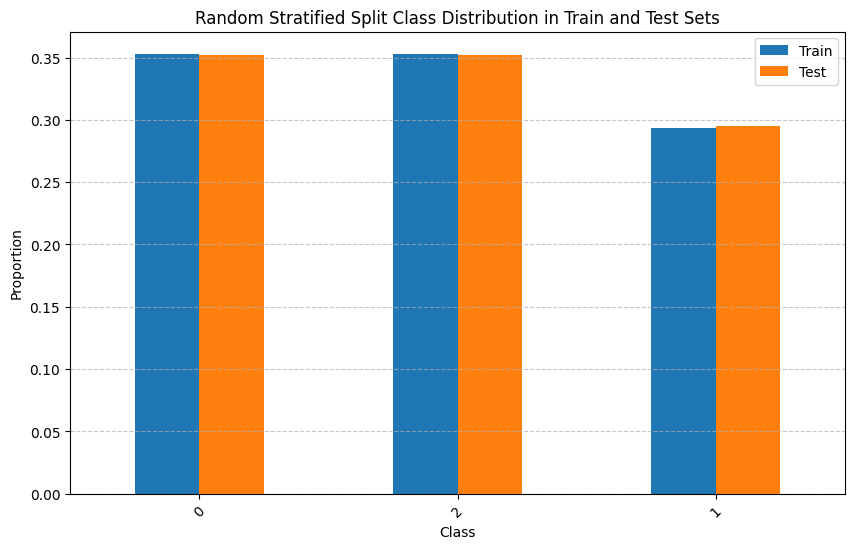

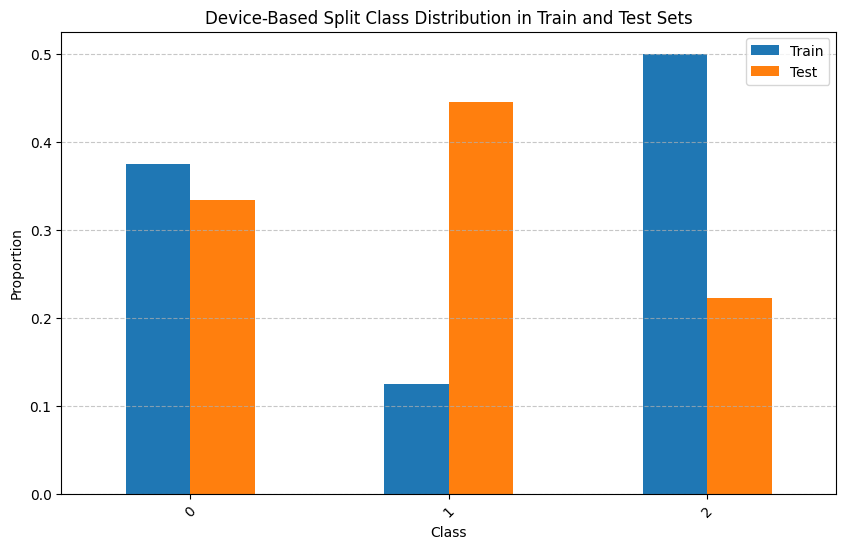

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Example data
# df = pd.DataFrame({'feature1': [...], 'device': [...], 'class': [...]})

def plot_class_distributions(train_set, test_set, title):
    # Calculate class distribution for train and test sets
    train_dist = train_set['label'].value_counts(normalize=True)
    test_dist = test_set['label'].value_counts(normalize=True)

    # Merge to align indices
    dist_df = pd.DataFrame({'Train': train_dist, 'Test': test_dist}).fillna(0)

    # Plot distributions
    dist_df.plot(kind='bar', figsize=(10, 6))
    plt.title(f"{title} Class Distribution in Train and Test Sets")
    plt.xlabel('Class')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Random stratified split
def stratified_random_split(df):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    splits = list(skf.split(df, df['label']))
    train_idx, test_idx = splits[0]  # First split
    train_set = df.iloc[train_idx]
    test_set = df.iloc[test_idx]
    return train_set, test_set

# Device-based split
def device_based_split(df):
    devices = df['bearing_id'].unique()
    # Randomly shuffle devices
    shuffled_devices = pd.Series(devices).sample(frac=1, random_state=42).values
    # Split devices into train and test
    train_devices = shuffled_devices[:len(shuffled_devices)//2]
    test_devices = shuffled_devices[len(shuffled_devices)//2:]
    # Create train and test sets
    train_set = df[df['bearing_id'].isin(train_devices)]
    test_set = df[df['bearing_id'].isin(test_devices)]
    return train_set, test_set

# Example usage
# Random stratified split
train_random, test_random = stratified_random_split(pu_features_df)

# Device-based split
train_device, test_device = device_based_split(pu_features_df)

# Plot distributions
plot_class_distributions(train_random, test_random, title='Random Stratified Split')
plot_class_distributions(train_device, test_device, title='Device-Based Split')


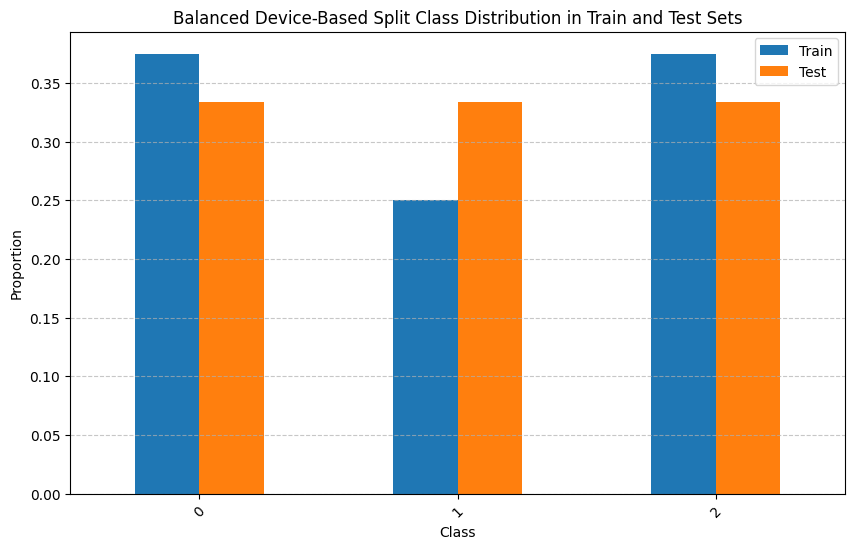

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate class distributions for each device
def calculate_device_class_distribution(df):
    return df.groupby('bearing_id')['label'].value_counts(normalize=True).unstack(fill_value=0)

# Function to split devices for balanced class distribution
def balanced_device_split(df):
    device_class_dist = calculate_device_class_distribution(df)
    
    # Sort devices by how much they contribute to class balance
    sorted_devices = device_class_dist.index.tolist()
    train_devices, test_devices = [], []
    train_classes, test_classes = pd.Series(0, index=device_class_dist.columns), pd.Series(0, index=device_class_dist.columns)
    
    # Assign devices to train or test while keeping class proportions balanced
    for device in sorted_devices:
        if (train_classes + device_class_dist.loc[device]).max() < (test_classes + device_class_dist.loc[device]).max():
            train_devices.append(device)
            train_classes += device_class_dist.loc[device]
        else:
            test_devices.append(device)
            test_classes += device_class_dist.loc[device]
    
    # Create train and test sets
    train_set = df[df['bearing_id'].isin(train_devices)]
    test_set = df[df['bearing_id'].isin(test_devices)]
    return train_set, test_set

# Function to plot class distributions
def plot_class_distributions(train_set, test_set, title):
    train_dist = train_set['label'].value_counts(normalize=True)
    test_dist = test_set['label'].value_counts(normalize=True)
    dist_df = pd.DataFrame({'Train': train_dist, 'Test': test_dist}).fillna(0)

    dist_df.plot(kind='bar', figsize=(10, 6))
    plt.title(f"{title} Class Distribution in Train and Test Sets")
    plt.xlabel('Class')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
train_device, test_device = balanced_device_split(pu_features_df)
plot_class_distributions(train_device, test_device, title='Balanced Device-Based Split')


## DNN


#### Base model size comparison

In [170]:
models = {
    'model_1': [8, 16, 8],
    'model_2': [16, 32, 16],
    'model_3': [12, 32, 64, 32, 12],
    'model_4': [32, 64, 128, 64, 32],
    'model_5': [64, 128, 256, 128, 64],
    'model_6': [64, 256, 128, 256, 64]
    }


In [138]:
import tf_keras as keras
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

epochs = 50
batch_size = 4

# Initialize results for accuracies and losses
results = {name: {'accuracy': [], 'loss': []} for name in models.keys()}

for name, layers in models.items():
    for i in range(len(folds)):
        (X_train, X_test, y_train, y_test) = folds[i]
        model = create_model(layers, input_shape, output_shape)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        results[name]['accuracy'].append(accuracy)
        results[name]['loss'].append(loss)
        print(f"Model {name}, Fold {i+1}: Accuracy = {accuracy}, Loss = {loss}")


Model model_1, Fold 1: Accuracy = 0.9301470518112183, Loss = 0.15991093218326569
Model model_1, Fold 2: Accuracy = 0.9411764740943909, Loss = 0.18372303247451782
Model model_1, Fold 3: Accuracy = 0.9522058963775635, Loss = 0.15761294960975647
Model model_1, Fold 4: Accuracy = 0.9007353186607361, Loss = 0.2353171706199646
Model model_1, Fold 5: Accuracy = 0.9154411554336548, Loss = 0.17834746837615967
Model model_2, Fold 1: Accuracy = 0.9448529481887817, Loss = 0.13882653415203094
Model model_2, Fold 2: Accuracy = 0.9264705777168274, Loss = 0.1742457151412964
Model model_2, Fold 3: Accuracy = 0.9485294222831726, Loss = 0.14301873743534088
Model model_2, Fold 4: Accuracy = 0.9301470518112183, Loss = 0.2118823528289795
Model model_2, Fold 5: Accuracy = 0.9558823704719543, Loss = 0.11396003514528275
Model model_3, Fold 1: Accuracy = 0.9301470518112183, Loss = 0.13823993504047394
Model model_3, Fold 2: Accuracy = 0.9411764740943909, Loss = 0.19181214272975922
Model model_3, Fold 3: Accuracy

C:\Users\joris\AppData\Local\Temp\ipykernel_48292\2406445670.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(accuracies, labels=model_names, patch_artist=True)


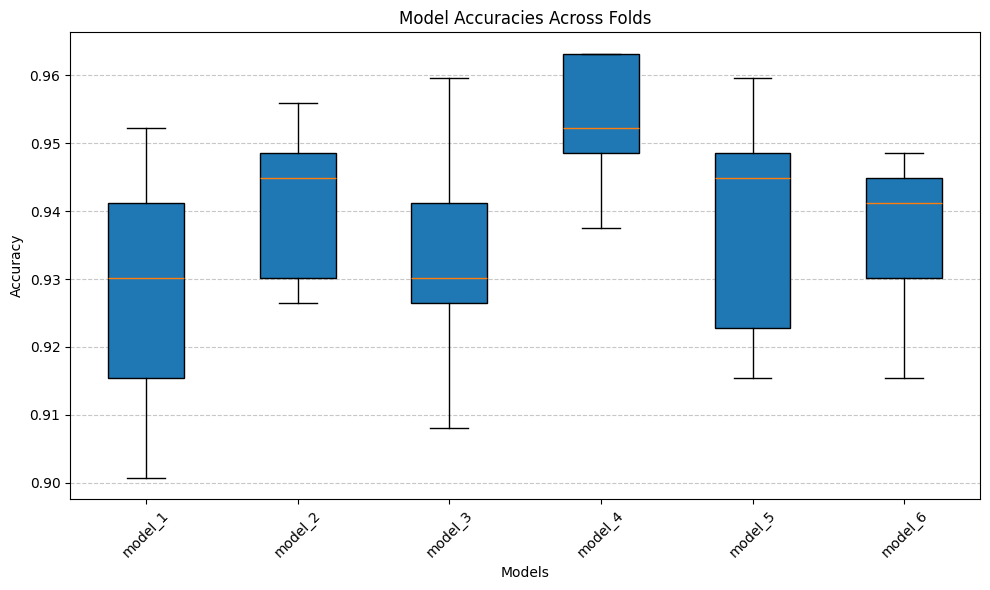

In [143]:
# Extract data for boxplot
model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in model_names]

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(accuracies, labels=model_names, patch_artist=True)
plt.title("Model Accuracies Across Folds")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Base Model

In [171]:
epochs = 50
batch_size = 4

models_dict = {}
chosen_layers_structure  = models['model_4']
model_name = 'base_model'

for i in range(len(folds)):
    (X_train, X_test, y_train, y_test) = folds[i]
    print(f"Running fold {i+1} out of {len(folds)}")
    model_name_fold = model_name + f'_{i+1}'

    model = create_model(chosen_layers_structure, input_shape, output_shape)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
    float_tflite_model = float_converter.convert()

    # Save the model
    models_dict[model_name_fold] = {
        'model': model,
        'train accuracy': train_accuracy,
        'test accuracy': test_accuracy,
        'size': get_size_model(float_tflite_model),
        'param count': model.count_params(),
        'sparsity': calculate_sparsity(model),
        'is_quantized': False
        }

Running fold 1 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmptnjh71t8\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmptnjh71t8\assets


Running fold 2 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp8aqj7_v8\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp8aqj7_v8\assets


Running fold 3 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpi7em88ma\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpi7em88ma\assets


Running fold 4 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp3gbc_p64\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp3gbc_p64\assets


Running fold 5 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpdy2jb0d1\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpdy2jb0d1\assets


#### Pruning

In [7]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.quantization.keras import quantize_model

##### Evaluation

In [148]:
# Define different sparsity levels to test
sparsity_levels = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 

ft_epochs_prune = 10
ft_epochs_quant = 10

sparisty_results = {}

for sparsity in sparsity_levels:
    print(f"\nTesting Sparsity Level: {sparsity}\n")
    
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0, 
            final_sparsity=sparsity, 
            begin_step=0, 
            end_step=len(folds[0][0]) // batch_size * ft_epochs_prune  # Adjust end step based on fine-tuning epochs
        )
    }
    
    for i in range(len(folds)):
        (X_train, X_test, y_train, y_test) = folds[i]
        print(f"Running fold {i+1} out of {len(folds)} for sparsity {sparsity}")

        # Get model from metrics for associated label
        original_model = models_dict[f'base_model_{i+1}']['model']

        # Create a fresh copy of the base model
        model = clone_model(original_model)
        model.set_weights(original_model.get_weights())

        # Prune the model with the current sparsity level
        pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
        pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
        pruned_model.fit(X_train, y_train, epochs=ft_epochs_prune, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=callbacks)
        _, train_accuracy = pruned_model.evaluate(X_train, y_train, verbose=0)
        _, test_accuracy = pruned_model.evaluate(X_test, y_test, verbose=0)

        # Strip pruning for quantization
        stripped_model = strip_pruning(pruned_model)

        # Convert pruned model to TFLite      
        float_converter = tf.lite.TFLiteConverter.from_keras_model(stripped_model)
        float_tflite_model = float_converter.convert()

        sparisty_results[f'pruned_model_sparsity_{int(sparsity*100)}_{i+1}'] = {
            'model': pruned_model,
            'train accuracy': train_accuracy,
            'test accuracy': test_accuracy,
            'size': get_size_model(float_tflite_model),
            'param count': pruned_model.count_params(),
            'sparsity': calculate_sparsity(pruned_model)
        }

        # # Quantize the pruned model
        # to_be_quantized = clone_model(stripped_model)
        # to_be_quantized.set_weights(original_model.get_weights())
        # pruned_quantized_model = quantize_model(to_be_quantized) ### !!!!!  

        # pruned_quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        # pruned_quantized_model.fit(X_train, y_train, epochs=ft_epochs_quant, batch_size=batch_size, validation_split=0.2, verbose=0)
        # _, train_accuracy = pruned_quantized_model.evaluate(X_train, y_train, verbose=0)
        # _, test_accuracy = pruned_quantized_model.evaluate(X_test, y_test, verbose=0)

        # pruned_converter = tf.lite.TFLiteConverter.from_keras_model(pruned_quantized_model)
        # pruned_converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # pruned_quantized_tflite_model = pruned_converter.convert()

        # sparisty_results[f'pruned_quan_model_sparsity_{int(sparsity*100)}_{i+1}'] = {
        #     'model': pruned_quantized_model,
        #     'train accuracy': train_accuracy,
        #     'test accuracy': test_accuracy,
        #     'size': get_size_model(pruned_quantized_tflite_model),
        #     'param count': pruned_quantized_model.count_params(),
        #     'sparsity': calculate_sparsity(pruned_quantized_model)
        # }





Testing Sparsity Level: 0.3

Running fold 1 out of 5 for sparsity 0.3
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpk_bbrp2w\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpk_bbrp2w\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpb3o8zgqe\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpb3o8zgqe\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 2 out of 5 for sparsity 0.3
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpae6_vlmf\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpae6_vlmf\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpn8kr8ctz\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpn8kr8ctz\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 3 out of 5 for sparsity 0.3
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpuqnyegnj\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpuqnyegnj\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpnp94i5ku\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpnp94i5ku\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 4 out of 5 for sparsity 0.3
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpphqj97ic\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpphqj97ic\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp0w8_umbt\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp0w8_umbt\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 5 out of 5 for sparsity 0.3
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_bivg2mb\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_bivg2mb\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1d9euveh\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1d9euveh\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Testing Sparsity Level: 0.4

Running fold 1 out of 5 for sparsity 0.4
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2if92vec\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2if92vec\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpu1z400op\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpu1z400op\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 2 out of 5 for sparsity 0.4
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpgt616vwh\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpgt616vwh\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9blduqef\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9blduqef\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 3 out of 5 for sparsity 0.4
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp489vw8ax\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp489vw8ax\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprbgm222q\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprbgm222q\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 4 out of 5 for sparsity 0.4
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2qvz9fkl\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2qvz9fkl\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpqf1omkzv\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpqf1omkzv\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 5 out of 5 for sparsity 0.4
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpek0vd3su\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpek0vd3su\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpyan6l1et\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpyan6l1et\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Testing Sparsity Level: 0.5

Running fold 1 out of 5 for sparsity 0.5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpzy23_7ub\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpzy23_7ub\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1xk5eppn\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1xk5eppn\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 2 out of 5 for sparsity 0.5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp5s8el1yf\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp5s8el1yf\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpdv0ntagu\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpdv0ntagu\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 3 out of 5 for sparsity 0.5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpt4swo348\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpt4swo348\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_frcxd8y\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_frcxd8y\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 4 out of 5 for sparsity 0.5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp4emdmhve\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp4emdmhve\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_4wtun6d\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_4wtun6d\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 5 out of 5 for sparsity 0.5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpqos2z7oz\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpqos2z7oz\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpmjr2rkff\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpmjr2rkff\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Testing Sparsity Level: 0.6

Running fold 1 out of 5 for sparsity 0.6
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp3y8lalyg\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp3y8lalyg\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpy3bqs2rw\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpy3bqs2rw\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 2 out of 5 for sparsity 0.6
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpn_ky587_\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpn_ky587_\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpg4mdck6l\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpg4mdck6l\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 3 out of 5 for sparsity 0.6
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpt1d0teip\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpt1d0teip\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp0phole3l\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp0phole3l\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 4 out of 5 for sparsity 0.6
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpukd6nh6y\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpukd6nh6y\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpdfsq7g34\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpdfsq7g34\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 5 out of 5 for sparsity 0.6
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmps5ypus3s\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmps5ypus3s\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp5ks5qo9x\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp5ks5qo9x\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Testing Sparsity Level: 0.7

Running fold 1 out of 5 for sparsity 0.7
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpur48_mn_\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpur48_mn_\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp8y3w6ukb\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp8y3w6ukb\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 2 out of 5 for sparsity 0.7
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp8jgvwr5y\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp8jgvwr5y\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpvq8f80pm\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpvq8f80pm\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 3 out of 5 for sparsity 0.7
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpbprdwawb\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpbprdwawb\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpnpv44ebx\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpnpv44ebx\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 4 out of 5 for sparsity 0.7
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1dh8b4iv\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1dh8b4iv\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp498qdi2v\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp498qdi2v\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 5 out of 5 for sparsity 0.7
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpay0kadc8\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpay0kadc8\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpua2w3r0z\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpua2w3r0z\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Testing Sparsity Level: 0.8

Running fold 1 out of 5 for sparsity 0.8
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp7aubnjmp\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp7aubnjmp\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6h1hsb2d\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6h1hsb2d\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 2 out of 5 for sparsity 0.8
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpr7d6zkv3\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpr7d6zkv3\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_kclxlo9\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_kclxlo9\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 3 out of 5 for sparsity 0.8
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmphtrnwu9h\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmphtrnwu9h\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp0fsikera\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp0fsikera\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 4 out of 5 for sparsity 0.8
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpr8nq3l6h\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpr8nq3l6h\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpovmg457x\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpovmg457x\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 5 out of 5 for sparsity 0.8
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpttmruiki\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpttmruiki\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmptsbsa8al\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmptsbsa8al\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Testing Sparsity Level: 0.9

Running fold 1 out of 5 for sparsity 0.9
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1p07xvt5\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1p07xvt5\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpxgkvse2x\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpxgkvse2x\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 2 out of 5 for sparsity 0.9
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp4g6je8ck\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp4g6je8ck\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprka4wraz\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprka4wraz\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 3 out of 5 for sparsity 0.9
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpw0z30ass\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpw0z30ass\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpec1o320u\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpec1o320u\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 4 out of 5 for sparsity 0.9
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_x5vff71\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_x5vff71\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpx4mtw2je\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpx4mtw2je\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 5 out of 5 for sparsity 0.9
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2bl6suo9\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2bl6suo9\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpjnve10i2\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpjnve10i2\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
for key, value in sparisty_results.items():
    print(f"\nKey: {key}")
    print(f"  Train Accuracy: {value['train accuracy']}")
    print(f"  Test Accuracy: {value['test accuracy']}")
    print(f"  Model Size (KB): {value['size']} KB")
    print(f"  Parameter Count: {value['param count']}")
    print(f"  Sparsity: {value['sparsity'] * 100:.2f}%")

# For checking if the masking ctually works, if it does then the sprasity should be 0 for pruned quantized models as well.


C:\Users\joris\AppData\Local\Temp\ipykernel_48292\2033310163.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(accuracies, labels=labels, **boxprops)


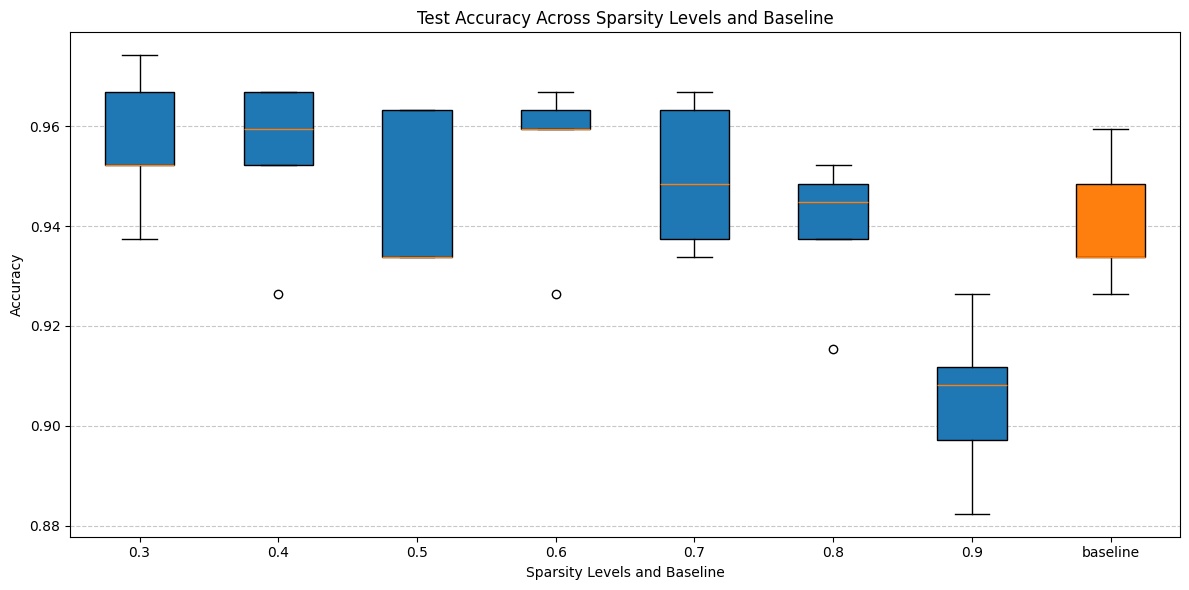

In [206]:
def extract_accuracy_data_with_baseline(sparisty_results, sparsity_levels, models_dict, num_folds):
    """
    Extracts test accuracy data for each sparsity level and includes baseline model accuracies.

    Args:
        sparisty_results (dict): Dictionary containing results for all sparsity levels and folds.
        sparsity_levels (list): List of tested sparsity levels.
        models_dict (dict): Dictionary containing baseline model results.
        num_folds (int): Number of folds used in cross-validation.

    Returns:
        accuracy_data (dict): Dictionary mapping sparsity levels and baseline to lists of test accuracies.
    """
    accuracy_data = {level: [] for level in sparsity_levels}
    accuracy_data["baseline"] = []  # Add baseline key

    # Extract accuracies for sparsity levels
    for key, value in sparisty_results.items():
        for level in sparsity_levels:
            if f"sparsity_{level}" in key and "pruned_model" in key:  # Only consider pruned model results
                accuracy_data[level].append(value["test accuracy"])

    # Extract baseline model accuracies
    for i in range(1, num_folds + 1):
        accuracy_data["baseline"].append(models_dict[f'base_model_{i}']['test accuracy'])

    return accuracy_data

def plot_accuracy_boxplot_with_baseline(accuracy_data):
    """
    Plots accuracy (boxplot) for each sparsity level and the baseline model, with a different color for the baseline.

    Args:
        accuracy_data (dict): Accuracy data for each sparsity level and baseline.
    """
    labels = list(accuracy_data.keys())
    accuracies = [accuracy_data[label] for label in labels]

    # Create the figure
    plt.figure(figsize=(12, 6))
    boxprops = dict(patch_artist=True)

    # Create the boxplot
    boxplot = plt.boxplot(accuracies, labels=labels, **boxprops)

    # Customize box colors
    for i, box in enumerate(boxplot['boxes']):
        if labels[i] == "baseline":
            box.set_facecolor('C1')  # Set the baseline color
        else:
            box.set_facecolor('C0')  # Set the sparsity-level colors

    # Add additional plot details
    plt.title("Test Accuracy Across Sparsity Levels and Baseline")
    plt.xlabel("Sparsity Levels and Baseline")
    plt.ylabel("Accuracy")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Extract accuracy data including the baseline model
accuracy_data = extract_accuracy_data_with_baseline(sparisty_results, sparsity_levels, models_dict, len(folds))

# Plot accuracy boxplot
plot_accuracy_boxplot_with_baseline(accuracy_data)


##### Actual

In [23]:
def count_non_zero_params(model):
    non_zero_count = 0
    for layer in model.layers:
        if hasattr(layer, 'weights'):
            for weight in layer.weights:
                if 'kernel' in weight.name:  # Focus on weight matrices, not biases
                    non_zero_count += np.count_nonzero(weight.numpy())
    return non_zero_count


def calculate_non_zero_params(model):
    total_params = 0
    zero_params = 0

    for layer in model.layers:
        weights = layer.get_weights()
        for w in weights:
            total_params += np.prod(w.shape)
            zero_params += np.sum(w == 0)

    non_zero = total_params - zero_params
    # sparsity = zero_params / total_params
    return non_zero

# Define a custom clone function to handle quantization layers
def clone_quantized_model(model):
    return tf.keras.models.clone_model(
        model,
        clone_function=lambda layer: layer.__class__.from_config(layer.get_config())
        if isinstance(layer, tfmot.quantization.keras.QuantizeWrapperV2)
        else layer
    )

In [43]:
fine_tune_epochs = 10

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.4, begin_step=0, end_step=len(folds[0][0]) // batch_size * fine_tune_epochs
    )
}

for i in range(len(folds)):
    (X_train, X_test, y_train, y_test) = folds[i]
    print(f"Running fold {i+1} out of {len(folds)}")

    # Get model from metrics for associated label
    original_model = models_dict[f'base_model_{i+1}']['model']

    ########################################################
    # Create a fresh copy of the base model
    model = clone_model(original_model)
    model.set_weights(original_model.get_weights())

    # Prune the Model
    pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
    pruned_model.fit(X_train, y_train, epochs=fine_tune_epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=callbacks)
    _, train_accuracy = pruned_model.evaluate(X_train, y_train, verbose=0)
    _, test_accuracy = pruned_model.evaluate(X_test, y_test, verbose=0)

    # Strip pruning for further steps
    stripped_model = strip_pruning(pruned_model) # Remove pruning wrappers so that we can quantize the model. Pruning wrappers are used for training only.

    float_converter = tf.lite.TFLiteConverter.from_keras_model(stripped_model)
    float_tflite_model = float_converter.convert()

    models_dict[f'pruned_model_{i+1}'] = {
        'model': pruned_model,
        'train accuracy': train_accuracy,
        'test accuracy': test_accuracy,
        'size': get_size_model(float_tflite_model),
        'param count': calculate_non_zero_params(stripped_model),
        # 'param count': pruned_model.count_params(),
        'sparsity': calculate_sparsity(pruned_model),
        'is_quantized': False
        }

    # Quantize the Pruned Model 
    to_be_quantized = clone_model(stripped_model)
    to_be_quantized.set_weights(original_model.get_weights())
    # annotated_model= tfmot.quantization.keras.quantize_annotate_model(to_be_quantized)
    # pruned_quantized_model = tfmot.quantization.keras.quantize_apply(annotated_model)
    pruned_quantized_model = quantize_model(to_be_quantized) ### !!!!!  
    
    pruned_quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    pruned_quantized_model.fit(X_train, y_train, epochs=fine_tune_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    _, train_accuracy = pruned_quantized_model.evaluate(X_train, y_train, verbose=0)
    _, test_accuracy = pruned_quantized_model.evaluate(X_test, y_test, verbose=0)

    pruned_converter = tf.lite.TFLiteConverter.from_keras_model(pruned_quantized_model)
    pruned_converter.optimizations = [tf.lite.Optimize.DEFAULT]
    pruned_quantized_tflite_model = pruned_converter.convert()

    models_dict[f'pruned_quan_model_{i+1}'] = {
        'model': pruned_quantized_model,
        'train accuracy': train_accuracy,
        'test accuracy': test_accuracy,
        'size': get_size_model(pruned_quantized_tflite_model),
        'param count': calculate_non_zero_params(stripped_model),
        # 'param count': pruned_quantized_model.count_params(),
        'sparsity': calculate_sparsity(pruned_quantized_model),
        'is_quantized': True
        }
    

    # ########################################################
    # # Quantize the Model and then Prune it
    # # Create a fresh copy of the base model
    # model = clone_model(original_model)
    # model.set_weights(original_model.get_weights())

    # quantize_model = tfmot.quantization.keras.quantize_model
    # quantized_model = quantize_model(model)
    # quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # history = quantized_model.fit(X_train, y_train, epochs=fine_tune_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    # _, train_accuracy = quantized_model.evaluate(X_train, y_train, verbose=0)
    # _, test_accuracy = quantized_model.evaluate(X_test, y_test, verbose=0)

    # converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # quantized_tflite_model = converter.convert()

    # models_dict[f'quan_model_{i+1}'] = {
    #     'model': quantized_model,
    #     'train accuracy': train_accuracy,
    #     'test accuracy': test_accuracy,
    #     'size': get_size_model(quantized_tflite_model),
    #     'param count': calculate_non_zero_params(quantized_model),
    #     # 'param count': quantized_model.count_params(),
    #     'sparsity': calculate_sparsity(quantized_model)
    #     }
    
    # # Prune the quantized model
    # # to_be_pruned = clone_model(quantized_model)
    # # to_be_pruned.set_weights(quantized_model.get_weights())
    # to_be_pruned = quantized_model

    # pruned_quantized_model = tfmot.sparsity.keras.prune_low_magnitude(to_be_pruned, **pruning_params)
    # pruned_quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
    # pruned_quantized_model.fit(X_train, y_train, epochs=fine_tune_epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=callbacks)
    # _, train_accuracy = pruned_quantized_model.evaluate(X_train, y_train, verbose=0)
    # _, test_accuracy = pruned_quantized_model.evaluate(X_test, y_test, verbose=0)

    # stripped_model = strip_pruning(pruned_quantized_model)
    
    # converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # quantized_tflite_model = converter.convert()

    # models_dict[f'quan_pruned_model_{i+1}'] = {
    #     'model': pruned_quantized_model,
    #     'train accuracy': train_accuracy,
    #     'test accuracy': test_accuracy,
    #     'size': get_size_model(quantized_tflite_model),
    #     'param count': calculate_non_zero_params(stripped_model),
    #     # 'param count': pruned_quantized_model.count_params(),
    #     'sparsity': calculate_sparsity(pruned_quantized_model)
    #     }


Running fold 1 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp201fn5aj\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp201fn5aj\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpu6a3vl7d\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpu6a3vl7d\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 2 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmppgm6trqa\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmppgm6trqa\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2b6z5lsk\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2b6z5lsk\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 3 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpaqbp5_4e\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpaqbp5_4e\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmphbj7vsj8\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmphbj7vsj8\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 4 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmppgr3s8i8\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmppgr3s8i8\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp01lu4jkl\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp01lu4jkl\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 5 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpvhqzn3b3\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpvhqzn3b3\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpxqxhhzde\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpxqxhhzde\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


#### Quantization

In [44]:
for i in range(len(folds)):
    (X_train, X_test, y_train, y_test) = folds[i]
    print(f"Running fold {i+1} out of {len(folds)}")

    # Get model from metrics for associated label
    original_model = models_dict[f'base_model_{i+1}']['model']

    # Create a fresh copy of the base model
    model = clone_model(original_model)
    model.set_weights(original_model.get_weights())

    quantize_model = tfmot.quantization.keras.quantize_model
    quantized_model = quantize_model(model)
    quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = quantized_model.fit(X_train, y_train, epochs=fine_tune_epochs, batch_size=4, validation_split=0.2, verbose=0)
    _, train_accuracy = quantized_model.evaluate(X_train, y_train, verbose=0)
    _, test_accuracy = quantized_model.evaluate(X_test, y_test, verbose=0)

    converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantized_tflite_model = converter.convert()

    models_dict[f'quan_model_{i+1}'] = {
        'model': quantized_model,
        'train accuracy': train_accuracy,
        'test accuracy': test_accuracy,
        'size': get_size_model(quantized_tflite_model),
        'param count': quantized_model.count_params(),
        'sparsity': calculate_sparsity(quantized_model),
        'is_quantized': True
        }

Running fold 1 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpaqojjiqk\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpaqojjiqk\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 2 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpmrkv2nof\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpmrkv2nof\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 3 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpivy05g4p\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpivy05g4p\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 4 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmppz7zvk6c\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmppz7zvk6c\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Running fold 5 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpnt1_irfr\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpnt1_irfr\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


#### Decomp

In [30]:
from scipy.linalg import svd
def compress_model_with_svd(model, compression_factor=0.5):
    """
    Compresses a Keras model by applying SVD to Dense layers and replacing them
    with two lower-rank Dense layers.

    Parameters:
    - model (keras.Model): The original Keras model to compress.
    - compression_factor (float): The factor by which to reduce the rank (e.g., 0.5 for 50% reduction).

    Returns:
    - compressed_model (keras.Model): The compressed Keras model.
    """
    # Create a new model configuration
    compressed_model = keras.Sequential() # keras.model.Sequential()
    
    for layer in model.layers:
        if isinstance(layer, keras.layers.Dense):
            # Get weights and biases
            W, b = layer.get_weights()
            
            # Perform SVD on the weight matrix
            U, S, Vt = svd(W, full_matrices=False)
            
            # Determine new rank
            min_dim = min(W.shape)
            rank = max(1, int(min_dim * compression_factor))
            # Truncate U, S, Vt to the new rank
            U_r = U[:, :rank]
            S_r = np.diag(S[:rank])
            Vt_r = Vt[:rank, :]
            
            # # First Dense layer with reduced rank
            compressed_model.add(keras.layers.Dense(rank, activation='linear',  # No activation in the first layer
                                        input_shape=layer.input_shape[1:], use_bias=False))
            compressed_model.layers[-1].set_weights([U_r @ S_r])
            # # Second Dense layer to reconstruct the original layer

            compressed_model.add(keras.layers.Dense(layer.units, activation=layer.activation,  # Apply activation here
                                                    use_bias=True))
            compressed_model.layers[-1].set_weights([Vt_r, b])
        else:
            # For non-Dense layers, simply add them to the compressed model
            compressed_model.add(layer)
    
    return compressed_model

##### Evaluation

In [194]:
# Define different compression factors to test
compression_factors = [0.2, 0.3, 0.4, 0.5, 0.6]  # Example compression ratios

decomp_results = {}

for compression_factor in compression_factors:
    print(f"\nTesting Compression Factor: {compression_factor}\n")

    for i in range(len(folds)):
        (X_train, X_test, y_train, y_test) = folds[i]
        print(f"Running fold {i+1} out of {len(folds)} for compression factor {compression_factor}")

        # Get original base model
        original_model = models_dict[f'base_model_{i+1}']['model']

        # Clone the base model to ensure no modifications to the original model
        model = clone_model(original_model)
        model.set_weights(original_model.get_weights())

        # Step 1: Apply Tensor Decomposition (SVD) for Compression
        decomp_model = compress_model_with_svd(model, compression_factor=compression_factor)

        # Step 2: Compile the decomposed model
        decomp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Step 3: Fine-Tune the compressed model
        decomp_model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=4,
            validation_split=0.2,
            verbose=0
        )

        # Step 4: Evaluate on the test set
        loss, test_accuracy = decomp_model.evaluate(X_test, y_test, verbose=0)

        # Convert the decomposed model to TFLite and measure size
        converter = tf.lite.TFLiteConverter.from_keras_model(decomp_model)
        decomp_tflite_model = converter.convert()
        model_size = get_size_model(decomp_tflite_model)

        # Save results
        decomp_results[f'decomp_model_factor_{int(compression_factor * 100)}_{i+1}'] = {
            'model': decomp_model,
            'test accuracy': test_accuracy,
            'size': model_size,
            'param count': decomp_model.count_params(),
        }




Testing Compression Factor: 0.2

Running fold 1 out of 5 for compression factor 0.2
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp3ukrxijs\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp3ukrxijs\assets


Running fold 2 out of 5 for compression factor 0.2
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpkpfsde5l\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpkpfsde5l\assets


Running fold 3 out of 5 for compression factor 0.2
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpjf8m05hx\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpjf8m05hx\assets


Running fold 4 out of 5 for compression factor 0.2
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp3x0i9qmp\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp3x0i9qmp\assets


Running fold 5 out of 5 for compression factor 0.2
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp4835xr0l\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp4835xr0l\assets



Testing Compression Factor: 0.3

Running fold 1 out of 5 for compression factor 0.3
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprpl2gn5g\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprpl2gn5g\assets


Running fold 2 out of 5 for compression factor 0.3
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpzvekneji\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpzvekneji\assets


Running fold 3 out of 5 for compression factor 0.3
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmph1jydjdv\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmph1jydjdv\assets


Running fold 4 out of 5 for compression factor 0.3
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp4abb91l4\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp4abb91l4\assets


Running fold 5 out of 5 for compression factor 0.3
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpi_u69575\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpi_u69575\assets



Testing Compression Factor: 0.4

Running fold 1 out of 5 for compression factor 0.4
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprs_lzpxw\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprs_lzpxw\assets


Running fold 2 out of 5 for compression factor 0.4
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp7l8lyt9r\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp7l8lyt9r\assets


Running fold 3 out of 5 for compression factor 0.4
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpj8fmy2k9\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpj8fmy2k9\assets


Running fold 4 out of 5 for compression factor 0.4
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpjep6pu8t\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpjep6pu8t\assets


Running fold 5 out of 5 for compression factor 0.4
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp34vjwzsm\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp34vjwzsm\assets



Testing Compression Factor: 0.5

Running fold 1 out of 5 for compression factor 0.5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpbdr4rdin\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpbdr4rdin\assets


Running fold 2 out of 5 for compression factor 0.5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpoyygir5l\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpoyygir5l\assets


Running fold 3 out of 5 for compression factor 0.5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfxd0zlxy\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfxd0zlxy\assets


Running fold 4 out of 5 for compression factor 0.5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpt5_o6671\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpt5_o6671\assets


Running fold 5 out of 5 for compression factor 0.5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpdu1_b_lq\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpdu1_b_lq\assets



Testing Compression Factor: 0.6

Running fold 1 out of 5 for compression factor 0.6
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpycgflaoo\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpycgflaoo\assets


Running fold 2 out of 5 for compression factor 0.6
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpvacy37ud\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpvacy37ud\assets


Running fold 3 out of 5 for compression factor 0.6
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpnrmv57ar\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpnrmv57ar\assets


Running fold 4 out of 5 for compression factor 0.6
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmplla2dedt\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmplla2dedt\assets


Running fold 5 out of 5 for compression factor 0.6
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpl5bjfye0\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpl5bjfye0\assets


In [29]:

def extract_accuracy_data_with_baseline(decomp_results, compression_factors, models_dict, num_folds):
    """
    Extracts test accuracy data for each compression factor and includes baseline model accuracies.

    Args:
        decomp_results (dict): Results for decomposition models across folds.
        compression_factors (list): List of compression factors.
        models_dict (dict): Dictionary containing baseline model results.
        num_folds (int): Number of folds used in cross-validation.

    Returns:
        accuracy_data (dict): Accuracy data for each compression factor and baseline.
    """
    accuracy_data = {factor: [] for factor in compression_factors}
    accuracy_data["baseline"] = []  # Add baseline key

    # Extract accuracies for compression factors
    for key, value in decomp_results.items():
        for factor in compression_factors:
            if f"factor_{int(factor * 100)}" in key:
                accuracy_data[factor].append(value["test accuracy"])

    # Extract baseline model accuracies
    for i in range(1, num_folds + 1):
        accuracy_data["baseline"].append(models_dict[f'base_model_{i}']['test accuracy'])

    return accuracy_data


def plot_accuracy_boxplot_for_decomposition(accuracy_data):
    """
    Plots accuracy (boxplot) for each compression factor and the baseline model, with a different color for the baseline.

    Args:
        accuracy_data (dict): Accuracy data for each compression factor and baseline.
    """
    labels = list(accuracy_data.keys())
    accuracies = [accuracy_data[label] for label in labels]

    # Create the figure
    plt.figure(figsize=(12, 6))
    boxprops = dict(patch_artist=True)

    # Create the boxplot
    boxplot = plt.boxplot(accuracies, labels=labels, **boxprops)

    # Customize box colors
    for i, box in enumerate(boxplot['boxes']):
        if labels[i] == "baseline":
            box.set_facecolor('C1')  # Set the baseline color
        else:
            box.set_facecolor('C0')  # Set the compression-factor colors

    # Add additional plot details
    plt.title("Test Accuracy Across Compression Factors and Baseline")
    plt.xlabel("Compression Factors and Baseline")
    plt.ylabel("Accuracy")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Extract data
accuracy_data = extract_accuracy_data_with_baseline(decomp_results, compression_factors, models_dict, len(folds))

# Plot the accuracy boxplot
plot_accuracy_boxplot_for_decomposition(accuracy_data)



NameError: name 'decomp_results' is not defined

In [223]:
def plot_accuracy_and_size_for_decomposition(accuracy_data, size_data):
    """
    Plots accuracy (boxplot) and model size (bar plot) for each compression factor and the baseline model.

    Args:
        accuracy_data (dict): Accuracy data for each compression factor and baseline.
        size_data (dict): Size data for each compression factor and baseline.
    """
    labels = list(accuracy_data.keys())
    accuracies = [accuracy_data[label] for label in labels]
    avg_sizes = [np.mean(size_data[label]) for label in labels]

    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot the boxplot for accuracies
    boxprops = dict(patch_artist=True)
    boxplot = ax1.boxplot(accuracies, labels=labels, **boxprops)

    # Customize box colors
    for i, box in enumerate(boxplot['boxes']):
        if labels[i] == "baseline":
            box.set_facecolor('C1')  # Set the baseline color
        else:
            box.set_facecolor('C0')  # Set the compression-factor colors

    # Add accuracy axis labels and grid
    ax1.set_ylabel("Accuracy", color='C0')
    ax1.tick_params(axis='y', labelcolor='C0')
    ax1.set_xlabel("Compression Factors and Baseline")
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot the bar plot for sizes on the secondary y-axis
    ax2 = ax1.twinx()
    bar_positions = range(1, len(labels) + 1)
    ax2.bar(bar_positions, avg_sizes, color='salmon', alpha=0.6, width=0.4, align='center', label="Model Size")
    ax2.set_ylabel("Model Size (KB)", color='salmon')
    ax2.tick_params(axis='y', labelcolor='salmon')

    # Add additional plot details
    plt.title("Test Accuracy and Model Size Across Compression Factors and Baseline")
    fig.tight_layout()
    plt.show()
def extract_accuracy_and_size_data_with_baseline(decomp_results, compression_factors, models_dict, num_folds):
    """
    Extracts test accuracy and model size data for each compression factor and baseline.

    Args:
        decomp_results (dict): Results for decomposition models across folds.
        compression_factors (list): List of compression factors.
        models_dict (dict): Dictionary containing baseline model results.
        num_folds (int): Number of folds.

    Returns:
        accuracy_data (dict): Accuracy data for each compression factor and baseline.
        size_data (dict): Size data for each compression factor and baseline.
    """
    accuracy_data = {factor: [] for factor in compression_factors}
    size_data = {factor: [] for factor in compression_factors}
    accuracy_data["baseline"] = []
    size_data["baseline"] = []

    # Extract accuracies and sizes for compression factors
    for key, value in decomp_results.items():
        for factor in compression_factors:
            if f"factor_{int(factor * 100)}" in key:
                accuracy_data[factor].append(value["test accuracy"])
                size_data[factor].append(value["size"])

    # Extract baseline model accuracies and sizes
    for i in range(1, num_folds + 1):
        accuracy_data["baseline"].append(models_dict[f'base_model_{i}']['test accuracy'])
        size_data["baseline"].append(models_dict[f'base_model_{i}']['param count'])

    return accuracy_data, size_data


C:\Users\joris\AppData\Local\Temp\ipykernel_48292\3676413241.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax1.boxplot(accuracies, labels=labels, **boxprops)


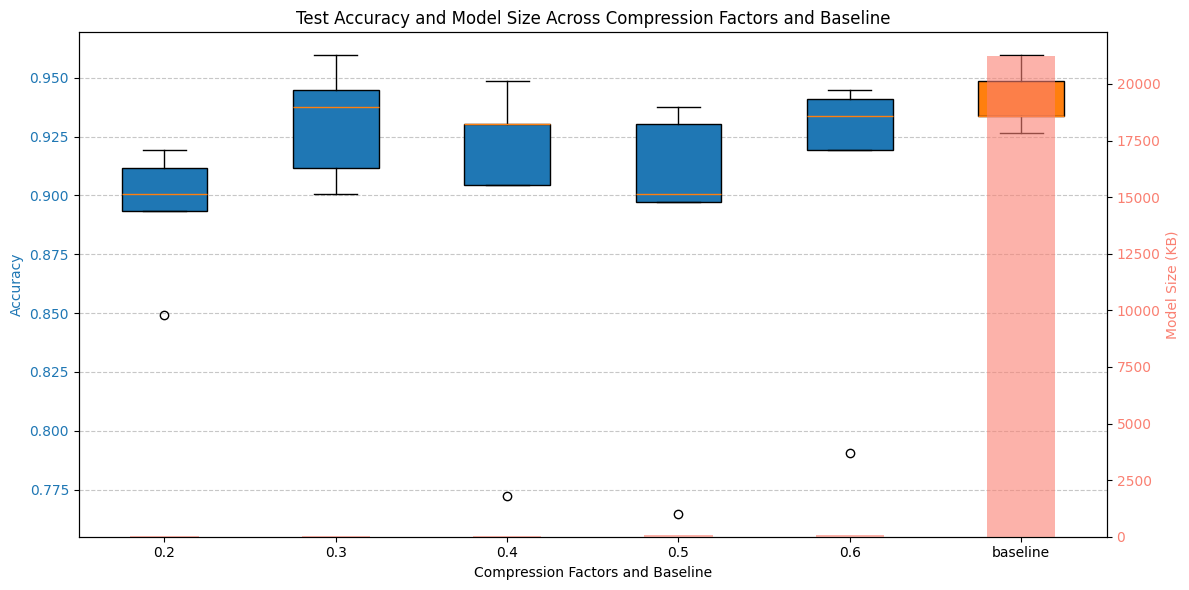

In [224]:
# Extract data
accuracy_data, size_data = extract_accuracy_and_size_data_with_baseline(decomp_results, compression_factors, models_dict, len(folds))

# Plot accuracy and size
plot_accuracy_and_size_for_decomposition(accuracy_data, size_data)


##### Actual

In [45]:
# Define compression factor for SVD
compression_factor = 0.3 # Compress layers to 20% of their original rank

for i in range(len(folds)):
    (X_train, X_test, y_train, y_test) = folds[i]
    print(f"\nRunning Fold {i+1} out of {len(folds)} for Matrix Decomposition (SVD)\n")

    # Get original base model from metrics
    original_model = models_dict[f'base_model_{i+1}']['model']

    # Clone the base model to ensure no modifications to the original model
    model = clone_model(original_model)
    model.set_weights(original_model.get_weights())

    # Step 1: Apply Tensor Decomposition (SVD) for Compression
    decomp_model = compress_model_with_svd(model, compression_factor=compression_factor)
    # Step 2: Compile the decomposed model
    decomp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Step 3: Fine-Tune the compressed model
    decomp_model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0
    )

    _, train_accuracy = decomp_model.evaluate(X_train, y_train, verbose=0)
    _, test_accuracy = decomp_model.evaluate(X_test, y_test, verbose=0)

    # Step 4: Evaluate on the test set
    loss, accuracy = decomp_model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {i+1} - Accuracy: {accuracy}, Loss: {loss}")

    # Step 5: Convert the decomposed model to TFLite and measure size
    converter = tf.lite.TFLiteConverter.from_keras_model(decomp_model)
    decomp_tflite_model = converter.convert()

    # Save results
    models_dict[f'decomp_model_{i+1}'] = {
        'model': decomp_model,
        'train accuracy': train_accuracy,
        'test accuracy': test_accuracy,
        'size': get_size_model(decomp_tflite_model),
        'param count': decomp_model.count_params(),
        'sparsity': calculate_sparsity(decomp_model),
        'is_quantized': False
        }



Running Fold 1 out of 5 for Matrix Decomposition (SVD)

Fold 1 - Accuracy: 0.8676470518112183, Loss: 0.33260035514831543
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp5uygptlh\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp5uygptlh\assets



Running Fold 2 out of 5 for Matrix Decomposition (SVD)

Fold 2 - Accuracy: 0.9117646813392639, Loss: 0.3070821762084961
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmplfp9bff5\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmplfp9bff5\assets



Running Fold 3 out of 5 for Matrix Decomposition (SVD)

Fold 3 - Accuracy: 0.966911792755127, Loss: 0.10879316180944443
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp0mo4hd3n\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp0mo4hd3n\assets



Running Fold 4 out of 5 for Matrix Decomposition (SVD)

Fold 4 - Accuracy: 0.904411792755127, Loss: 0.2749609053134918
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpl3031kp0\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpl3031kp0\assets



Running Fold 5 out of 5 for Matrix Decomposition (SVD)

Fold 5 - Accuracy: 0.9375, Loss: 0.2548225522041321
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpm9cvhyna\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpm9cvhyna\assets


In [46]:
# Define compression factor for SVD

for i in range(len(folds)):
    (X_train, X_test, y_train, y_test) = folds[i]
    print(f"\nRunning Fold {i+1} out of {len(folds)} for Quantiztion of Decomp Models\n")

    # Get original base model from metrics
    original_model = models_dict[f'decomp_model_{i+1}']['model']

    # Clone the base model to ensure no modifications to the original model
    model = clone_model(original_model)
    model.set_weights(original_model.get_weights())
    
    quantize_model = tfmot.quantization.keras.quantize_model
    quantized_model = quantize_model(model)
    quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = quantized_model.fit(X_train, y_train, epochs=20, batch_size=4, validation_split=0.2, verbose=0)
    _, train_accuracy = quantized_model.evaluate(X_train, y_train, verbose=0)
    _, test_accuracy = quantized_model.evaluate(X_test, y_test, verbose=0)

    converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantized_tflite_model = converter.convert()

    models_dict[f'decomp_quan_model_{i+1}'] = {
    'model': quantized_model,
    'train accuracy': train_accuracy,
    'test accuracy': test_accuracy,
    'size': get_size_model(quantized_tflite_model),
    'param count': quantized_model.count_params(),
    'sparsity': calculate_sparsity(quantized_model),
    'is_quantized': True
    }



Running Fold 1 out of 5 for Quantiztion of Decomp Models

INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpe1x5zhxq\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpe1x5zhxq\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Running Fold 2 out of 5 for Quantiztion of Decomp Models

INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp61_oobfz\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp61_oobfz\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Running Fold 3 out of 5 for Quantiztion of Decomp Models

INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_dwvg70a\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_dwvg70a\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Running Fold 4 out of 5 for Quantiztion of Decomp Models

INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfaja3kij\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfaja3kij\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



Running Fold 5 out of 5 for Quantiztion of Decomp Models

INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp17766f_m\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp17766f_m\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


### Total


In [136]:
epochs = 50
batch_size = 4
fine_tune_epochs = 10

models_dict = {}
chosen_layers_structure  = models['model_4']
quantize_model = tfmot.quantization.keras.quantize_model


for i in range(len(folds)):
    (X_train, X_test, y_train, y_test) = folds[i]
    print(f"Running fold {i+1} out of {len(folds)}")

    ########################################################
    ## Base Model
    model = create_model(chosen_layers_structure, input_shape, output_shape)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
    float_tflite_model = float_converter.convert()

    models_dict[f'Base_{i+1}'] = {
        'model': model,
        'train accuracy': train_accuracy,
        'test accuracy': test_accuracy,
        'size': get_size_model(float_tflite_model),
        'param count': model.count_params(),
        'non zero params': calculate_non_zero_params(model),
        'sparsity': calculate_sparsity(model),
        'quantized': False
        }
    
    ########################################################
    ## Quantize Base Model
    original_model = models_dict[f'Base_{i+1}']['model']
    to_be_quantized = clone_model(original_model)
    to_be_quantized.set_weights(original_model.get_weights())

    quantized_model = quantize_model(to_be_quantized)
    quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = quantized_model.fit(X_train, y_train, epochs=fine_tune_epochs, batch_size=4, validation_split=0.2, verbose=0)
    _, train_accuracy = quantized_model.evaluate(X_train, y_train, verbose=0)
    _, test_accuracy = quantized_model.evaluate(X_test, y_test, verbose=0)

    converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantized_tflite_model = converter.convert()

    models_dict[f'Quantized_{i+1}'] = {
        'model': quantized_model,
        'train accuracy': train_accuracy,
        'test accuracy': test_accuracy,
        'size': get_size_model(quantized_tflite_model),
        'param count': quantized_model.count_params(),
        'non zero params': calculate_non_zero_params(quantized_model),
        'sparsity': calculate_sparsity(quantized_model),
        'quantized': True
        }
    
    ########################################################
    ## Prune Base Model
    final_sparsity = [0.5, 0.6, 0.7]

    for sparsity_iter in final_sparsity:
        pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0, 
            final_sparsity=sparsity_iter, 
            begin_step=0, 
            end_step=len(folds[0][0]) // batch_size * fine_tune_epochs)}

        original_model = models_dict[f'Base_{i+1}']['model']
        to_be_pruned = clone_model(original_model)
        to_be_pruned.set_weights(original_model.get_weights())

        pruned_model = tfmot.sparsity.keras.prune_low_magnitude(to_be_pruned, **pruning_params)
        pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
        pruned_model.fit(X_train, y_train, epochs=fine_tune_epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=callbacks)
        _, train_accuracy = pruned_model.evaluate(X_train, y_train, verbose=0)
        _, test_accuracy = pruned_model.evaluate(X_test, y_test, verbose=0)

        stripped_model = strip_pruning(pruned_model) # Remove pruning wrappers so that we can quantize the model. Pruning wrappers are used for training only.

        float_converter = tf.lite.TFLiteConverter.from_keras_model(stripped_model)
        float_tflite_model = float_converter.convert()

        models_dict[f'Pruned ({sparsity_iter})_{i+1}'] = {
            'model': pruned_model,
            'train accuracy': train_accuracy,
            'test accuracy': test_accuracy,
            'size': get_size_model(float_tflite_model),
            'param count': stripped_model.count_params(),
            'non zero params': calculate_non_zero_params(stripped_model),
            'sparsity': calculate_sparsity(stripped_model),
            'quantized': False
            }
    
    ########################################################
    ## Quantize Pruned Base Model
        to_be_quantized = clone_model(stripped_model)
        to_be_quantized.set_weights(stripped_model.get_weights())

        quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
                to_be_quantized)
        pruned_quantized_model = tfmot.quantization.keras.quantize_apply(
                    quant_aware_annotate_model,
                    tfmot.experimental.combine.Default8BitClusterPreserveQuantizeScheme(preserve_sparsity=True))

        pruned_quantized_model.compile(optimizer='adam',
                    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
        pruned_quantized_model.fit(X_train, y_train, epochs=fine_tune_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
        # # Apply quantization-aware training to the pruned model
        # pruned_quantized_model = quantize_apply(to_be_quantized)
        # # pruned_quantized_model = quantize_model(to_be_quantized)
        
        # pruned_quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        # pruned_quantized_model.fit(X_train, y_train, epochs=fine_tune_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
        _, train_accuracy = pruned_quantized_model.evaluate(X_train, y_train, verbose=0)
        _, test_accuracy = pruned_quantized_model.evaluate(X_test, y_test, verbose=0)

        pruned_converter = tf.lite.TFLiteConverter.from_keras_model(pruned_quantized_model)
        pruned_converter.optimizations = [tf.lite.Optimize.DEFAULT]
        pruned_quantized_tflite_model = pruned_converter.convert()

        models_dict[f'Quantized Pruned ({sparsity_iter})_{i+1}'] = {
            'model': pruned_quantized_model,
            'train accuracy': train_accuracy,
            'test accuracy': test_accuracy,
            'size': get_size_model(pruned_quantized_tflite_model),
            'param count': pruned_quantized_model.count_params(),
            'non zero params': calculate_non_zero_params(pruned_quantized_model),
            'sparsity': calculate_sparsity(pruned_quantized_model),
            'quantized': True
            }
    
    ########################################################
    ## Decompose Base Model
    compression_factors = [0.2, 0.3, 0.4]

    for compression_factor in compression_factors:
        original_model = models_dict[f'Base_{i+1}']['model']
        to_be_decomposed = clone_model(original_model)
        to_be_decomposed.set_weights(original_model.get_weights())

        decomp_model = compress_model_with_svd(to_be_decomposed, compression_factor=compression_factor)
        decomp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        decomp_model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0
        )
        _, train_accuracy = decomp_model.evaluate(X_train, y_train, verbose=0)
        _, test_accuracy = decomp_model.evaluate(X_test, y_test, verbose=0)

        converter = tf.lite.TFLiteConverter.from_keras_model(decomp_model)
        decomp_tflite_model = converter.convert()

        # Save results
        models_dict[f'Decomposed ({compression_factor})_{i+1}'] = {
            'model': decomp_model,
            'train accuracy': train_accuracy,
            'test accuracy': test_accuracy,
            'size': get_size_model(decomp_tflite_model),
            'param count': decomp_model.count_params(),
            'non zero params': calculate_non_zero_params(decomp_model),
            'sparsity': calculate_sparsity(decomp_model),
            'quantized': False
            }
        
    ########################################################
        ## Quantize Decomposed Base Model
        to_be_quantized = clone_model(decomp_model)
        to_be_quantized.set_weights(decomp_model.get_weights())
        decomp_quantized_model = quantize_model(to_be_quantized)
        
        decomp_quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        decomp_quantized_model.fit(X_train, y_train, epochs=fine_tune_epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
        _, train_accuracy = decomp_quantized_model.evaluate(X_train, y_train, verbose=0)
        _, test_accuracy = decomp_quantized_model.evaluate(X_test, y_test, verbose=0)

        decomp_converter = tf.lite.TFLiteConverter.from_keras_model(decomp_quantized_model)
        decomp_converter.optimizations = [tf.lite.Optimize.DEFAULT]
        decomp_quantized_tflite_model = decomp_converter.convert()

        models_dict[f'Quantized Decomposed ({compression_factor})_{i+1}'] = {
            'model': decomp_quantized_model,
            'train accuracy': train_accuracy,
            'test accuracy': test_accuracy,
            'size': get_size_model(decomp_quantized_tflite_model),
            'param count': decomp_quantized_model.count_params(),
            'non zero params': calculate_non_zero_params(decomp_quantized_model),	
            'sparsity': calculate_sparsity(decomp_quantized_model),
            'quantized': True
            }
        





Running fold 1 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpx6p3ni2_\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpx6p3ni2_\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpnham030l\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpnham030l\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfi0cbeqd\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfi0cbeqd\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_799.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_800.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_801.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tenso

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpmpr2qsz8\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpmpr2qsz8\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprxszrmwc\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprxszrmwc\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_800.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_801.
Too many centroids to cluster.



c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2ahjpb67\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2ahjpb67\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6u8tzlhj\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6u8tzlhj\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_800.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_801.
Too many centroids to cluster.



c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpgjo393u5\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpgjo393u5\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpqwrw7h5g\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpqwrw7h5g\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpi18mv1hr\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpi18mv1hr\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpkb3paftt\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpkb3paftt\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpn5pnbf1t\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpn5pnbf1t\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprgqk1i65\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmprgqk1i65\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpq33c3tar\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpq33c3tar\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



Running fold 2 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpts3io1zf\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpts3io1zf\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp77nv9cqf\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp77nv9cqf\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfn1iortr\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfn1iortr\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_841.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_842.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_843.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tenso

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6mhr8bxb\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6mhr8bxb\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpozd80d5w\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpozd80d5w\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_842.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_843.
Too many centroids to cluster.



c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp31dqzb7k\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp31dqzb7k\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpa4p1a9ph\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpa4p1a9ph\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_842.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_843.
Too many centroids to cluster.



c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpk36s_xx7\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpk36s_xx7\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9g5kzfwc\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9g5kzfwc\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_jnilyu9\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_jnilyu9\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpypdbfrms\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpypdbfrms\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9dpo4dpm\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9dpo4dpm\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmps8715kng\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmps8715kng\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpzok79a2b\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpzok79a2b\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



Running fold 3 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpelkauget\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpelkauget\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpbgpoi_m9\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpbgpoi_m9\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpauc97mey\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpauc97mey\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_883.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_884.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_885.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tenso

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpwsuao4pz\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpwsuao4pz\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9qau3ve7\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9qau3ve7\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_884.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_885.
Too many centroids to cluster.



c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpis1azyv7\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpis1azyv7\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2mhlj902\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2mhlj902\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_884.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_885.
Too many centroids to cluster.



c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpt9dy02u0\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpt9dy02u0\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpiybmpden\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpiybmpden\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6bdgew0b\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6bdgew0b\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpwrybhmiq\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpwrybhmiq\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpynryvw_n\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpynryvw_n\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9zpwa746\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9zpwa746\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp5rv8eu7t\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp5rv8eu7t\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



Running fold 4 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1i8yb3by\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1i8yb3by\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp7m6vjfwe\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp7m6vjfwe\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfop94fbw\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfop94fbw\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_925.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_926.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_927.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tenso

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp06diizp7\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp06diizp7\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2oc_9ak5\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp2oc_9ak5\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_926.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_927.
Too many centroids to cluster.



c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfj1j_g90\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpfj1j_g90\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpkhf30ax1\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpkhf30ax1\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_926.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_927.
Too many centroids to cluster.



c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpyf7t3p25\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpyf7t3p25\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp02w6zmmd\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp02w6zmmd\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpt7im7d6h\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpt7im7d6h\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpson9fwlf\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpson9fwlf\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpe6w36bvd\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpe6w36bvd\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpeqmaz34d\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpeqmaz34d\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp5864nyhy\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp5864nyhy\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



Running fold 5 out of 5
INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpn5j0c82d\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpn5j0c82d\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpb4pfp8c5\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpb4pfp8c5\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9i_x5x3m\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp9i_x5x3m\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_967.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_968.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_969.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tenso

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1v7opkgd\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp1v7opkgd\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmplv9qtclj\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmplv9qtclj\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_968.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_969.
Too many centroids to cluster.



c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6i_l5u6d\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6i_l5u6d\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_lbrtwhp\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp_lbrtwhp\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_968.
Too many centroids to cluster.

c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow_model_optimization\python\core\quantization\keras\collab_opts\cluster_preserve\cluster_preserve_quantize_registry.py:367: UserWarning:

No clustering performed on layer quant_dense_969.
Too many centroids to cluster.



c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tf_keras\src\backend.py:5729: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp3p7vig7h\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp3p7vig7h\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpd6b539d_\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpd6b539d_\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpgib_fsrj\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpgib_fsrj\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpbi9xr4br\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpbi9xr4br\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmphe5w_dmy\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmphe5w_dmy\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6m_wydow\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmp6m_wydow\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpsdpn__dz\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmpsdpn__dz\assets
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



In [172]:
def plot_metric_vs_metric_with_legend(models_dict, x_metric, y_metric):
    """
    Plots one metric against another from models_dict with a legend placed outside the plot.

    Args:
        models_dict (dict): Dictionary containing model information.
        x_metric (str): Metric to be used for the x-axis (e.g., 'size', 'param count', 'non zero params', 'sparsity').
        y_metric (str): Metric to be used for the y-axis (e.g., 'test accuracy', 'train accuracy').

    Returns:
        None: Displays the plot.
    """
    x_values = []
    y_values = []
    labels = []
    categories = []

    for key, value in models_dict.items():
        if x_metric in value and y_metric in value:
            x_values.append(value[x_metric])
            y_values.append(value[y_metric])
            labels.append(key)
            categories.append("_".join(key.split("_")[:-1]))  # Group by model type (e.g., Base, Pruned)

    unique_categories = sorted(set(categories))
    category_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))

    plt.figure(figsize=(10, 6))
    for category, color in zip(unique_categories, category_colors):
        for i, cat in enumerate(categories):
            if cat == category:
                plt.scatter(
                    x_values[i], y_values[i], label=category if category not in plt.gca().get_legend_handles_labels()[1] else "",
                    alpha=0.8, edgecolor="k", s=50, color=color
                )

    # Label and Title
    plt.xlabel(x_metric.replace("_", " ").capitalize())
    plt.ylabel(y_metric.replace("_", " ").capitalize())
    plt.title(f"{y_metric.replace('_', ' ').capitalize()} vs {x_metric.replace('_', ' ').capitalize()}")

    # Place the legend outside the plot
    plt.legend(title="Model Types", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
    plt.grid(linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


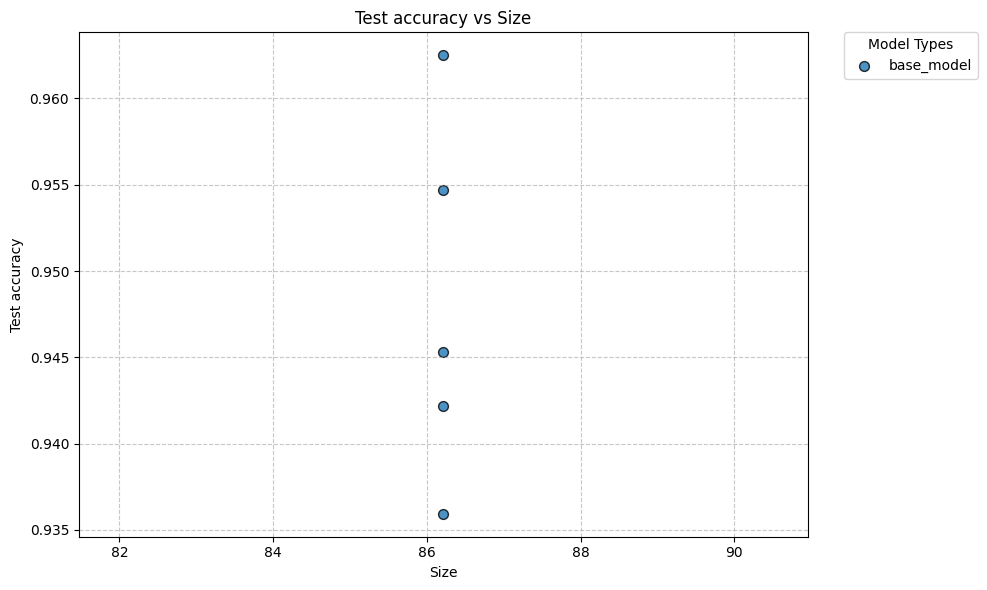

In [173]:
plot_metric_vs_metric_with_legend(models_dict, x_metric="size", y_metric="test accuracy")

In [79]:
def plot_metric_vs_metric_with_filter(
    models_dict, 
    x_metric, 
    y_metric, 
    model_types=None  # List of model types to include, e.g., ["Base", "Pruned", "Quantized Pruned"]
):
    """
    Plots one metric against another from models_dict with a legend placed outside the plot and allows filtering of model types.

    Args:
        models_dict (dict): Dictionary containing model information.
        x_metric (str): Metric to be used for the x-axis (e.g., 'size', 'param count', 'non zero params', 'sparsity').
        y_metric (str): Metric to be used for the y-axis (e.g., 'test accuracy', 'train accuracy').
        model_types (list or None): List of model types to include. Base is always included. If None, all models are plotted.

    Returns:
        None: Displays the plot.
    """
    x_values = []
    y_values = []
    labels = []
    categories = []

    # Always include base models
    include_model_types = ["Base"] if model_types is None else ["Base"] + model_types

    for key, value in models_dict.items():
        # Determine model type based on key
        model_type = "_".join(key.split("_")[:-1])  # Extract model type, e.g., "Base", "Pruned (0.3)"
        if model_type.split(" ")[0] in include_model_types and x_metric in value and y_metric in value:
            x_values.append(value[x_metric])
            y_values.append(value[y_metric])
            labels.append(key)
            categories.append(model_type)

    # Unique categories for color mapping
    unique_categories = sorted(set(categories))
    category_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))

    # Plot setup
    plt.figure(figsize=(12, 6))
    for category, color in zip(unique_categories, category_colors):
        for i, cat in enumerate(categories):
            if cat == category:
                plt.scatter(
                    x_values[i], y_values[i], label=category if category not in plt.gca().get_legend_handles_labels()[1] else "",
                    alpha=0.8, edgecolor="k", s=50, color=color
                )

    # Labels and Title
    plt.xlabel(x_metric.replace("_", " ").capitalize())
    plt.ylabel(y_metric.replace("_", " ").capitalize())
    plt.title(f"{y_metric.replace('_', ' ').capitalize()} vs {x_metric.replace('_', ' ').capitalize()}")

    # Place the legend outside the plot
    plt.legend(title="Model Types", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
    plt.grid(linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


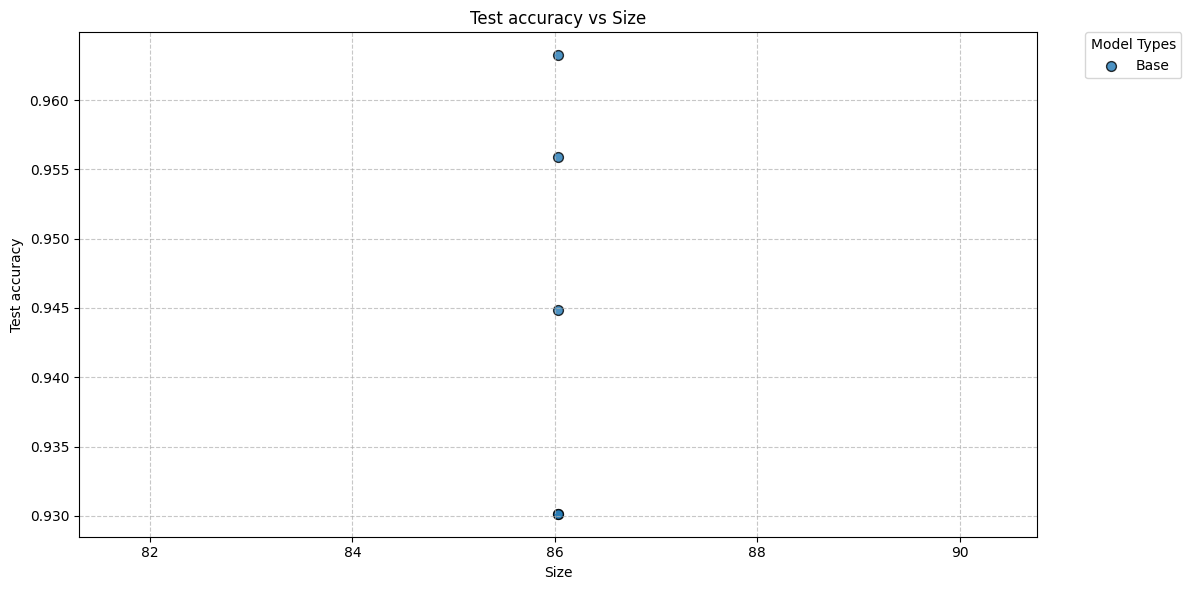

In [116]:
plot_metric_vs_metric_with_filter(
    models_dict, 
    x_metric="size", 
    y_metric="test accuracy", 
    model_types=None
)

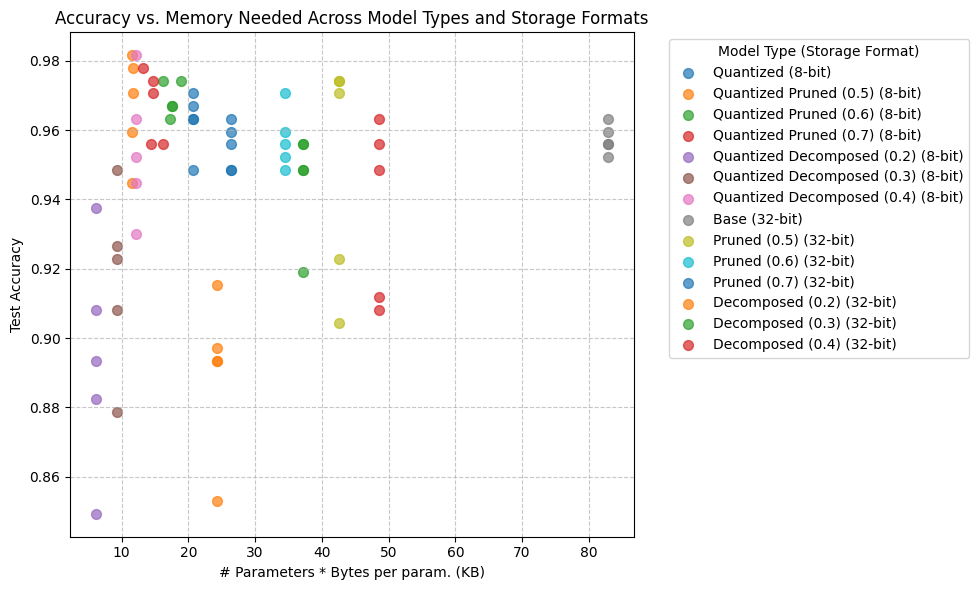

In [138]:
# Define storage format sizes in bytes
storage_formats = {
    '8-bit': 1,   # 1 byte per parameter
    '32-bit': 4   # 4 bytes per parameter
}

# Parse results for accuracy vs. memory needed
accuracy_vs_storage = []
for key, value in models_dict.items():
    model_name = '_'.join(key.split('_')[:-1])  # Extract model type (e.g., base_model, pruned_model)
    param_count = value['non zero params']
    accuracy = value['test accuracy']
    is_quantized = value['quantized']

    # Determine storage format based on quantization
    storage_format = '8-bit' if is_quantized else '32-bit'
    bytes_per_param = storage_formats[storage_format]
    memory_needed = param_count * bytes_per_param / 1024  # Convert to KB
    # memory_needed = value['size']

    accuracy_vs_storage.append({
        'model_name': model_name,
        'accuracy': accuracy,
        'storage_format': storage_format,
        'memory_needed': memory_needed
    })

# Convert to DataFrame for easier handling
df_storage = pd.DataFrame(accuracy_vs_storage)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
for storage_format in storage_formats.keys():
    subset = df_storage[df_storage['storage_format'] == storage_format]
    for model_type in subset['model_name'].unique():
        model_subset = subset[subset['model_name'] == model_type]
        plt.scatter(
            model_subset['memory_needed'], 
            model_subset['accuracy'], 
            label=f"{model_type} ({storage_format})", 
            s=50, 
            alpha=0.7
        )

# Add plot details
plt.title("Accuracy vs. Memory Needed Across Model Types and Storage Formats")
plt.xlabel("# Parameters * Bytes per param. (KB)")
# plt.xlabel('TFlite Model Size (KB)')
plt.ylabel("Test Accuracy")
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title="Model Type (Storage Format)", loc='best', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


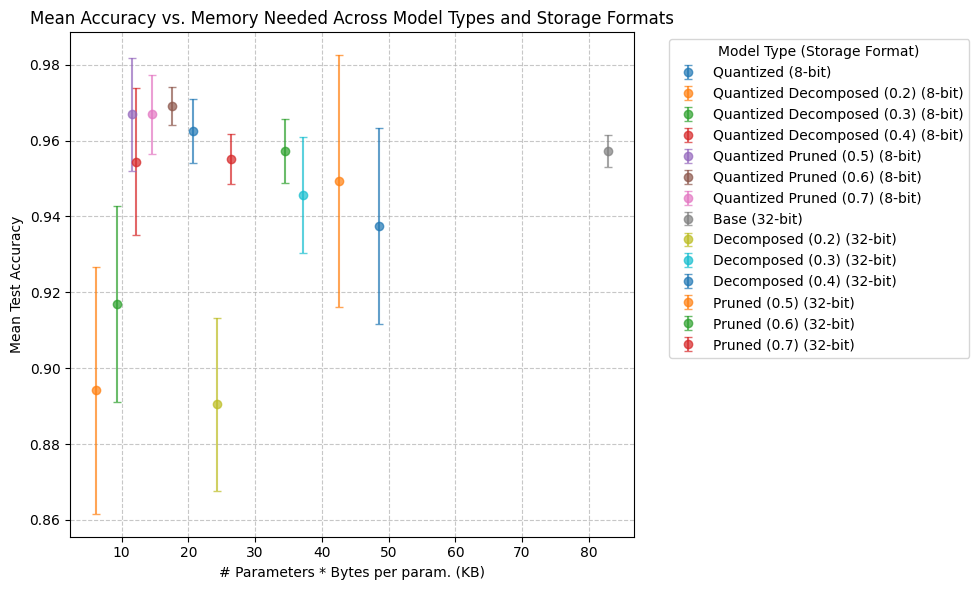

In [145]:
# Define storage format sizes in bytes
storage_formats = {
    '8-bit': 1,   # 1 byte per parameter
    '32-bit': 4   # 4 bytes per parameter
}

# Parse results for accuracy vs. memory needed
accuracy_vs_storage = []
for key, value in models_dict.items():
    model_name = '_'.join(key.split('_')[:-1])  # Extract model type (e.g., base_model, pruned_model)
    param_count = value['non zero params']
    accuracy = value['test accuracy']
    is_quantized = value['quantized']

    # Determine storage format based on quantization
    storage_format = '8-bit' if is_quantized else '32-bit'
    bytes_per_param = storage_formats[storage_format]
    memory_needed = param_count * bytes_per_param / 1024  # Convert to KB

    accuracy_vs_storage.append({
        'model_name': model_name,
        'accuracy': accuracy,
        'storage_format': storage_format,
        'memory_needed': memory_needed
    })

# Convert to DataFrame for easier handling
df_storage = pd.DataFrame(accuracy_vs_storage)

# Calculate mean and standard deviation for each model and storage format
summary = (
    df_storage
    .groupby(['model_name', 'storage_format'])[['accuracy', 'memory_needed']]
    .agg(['mean', 'std'])
    .reset_index()
)
summary.columns = ['model_name', 'storage_format', 'accuracy_mean', 'accuracy_std', 'memory_mean', 'memory_std']

# Plot the scatter plot
plt.figure(figsize=(10, 6))
for storage_format in storage_formats.keys():
    subset = summary[summary['storage_format'] == storage_format]
    for model_type in subset['model_name'].unique():
        model_subset = subset[subset['model_name'] == model_type]
        plt.errorbar(
            model_subset['memory_mean'],
            model_subset['accuracy_mean'],
            xerr=None,  # Optional: Add memory_std if desired
            yerr=model_subset['accuracy_std'] if 'accuracy_std' in summary.columns else None,
            fmt='o', 
            label=f"{model_type} ({storage_format})", 
            capsize=3,
            alpha=0.7
        )

# Add plot details
plt.title("Mean Accuracy vs. Memory Needed Across Model Types and Storage Formats")
plt.xlabel("# Parameters * Bytes per param. (KB)")
plt.ylabel("Mean Test Accuracy")
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title="Model Type (Storage Format)", loc='best', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


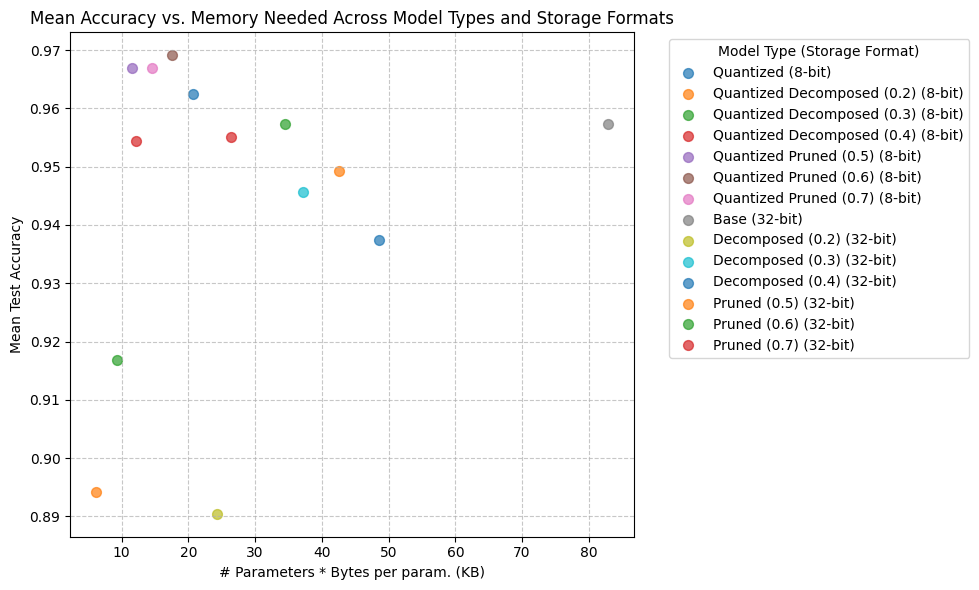

In [146]:
# Define storage format sizes in bytes
storage_formats = {
    '8-bit': 1,   # 1 byte per parameter
    '32-bit': 4   # 4 bytes per parameter
}

# Parse results for accuracy vs. memory needed
accuracy_vs_storage = []
for key, value in models_dict.items():
    model_name = '_'.join(key.split('_')[:-1])  # Extract model type (e.g., base_model, pruned_model)
    param_count = value['non zero params']
    accuracy = value['test accuracy']
    is_quantized = value['quantized']

    # Determine storage format based on quantization
    storage_format = '8-bit' if is_quantized else '32-bit'
    bytes_per_param = storage_formats[storage_format]
    memory_needed = param_count * bytes_per_param / 1024  # Convert to KB

    accuracy_vs_storage.append({
        'model_name': model_name,
        'accuracy': accuracy,
        'storage_format': storage_format,
        'memory_needed': memory_needed
    })

# Convert to DataFrame for easier handling
df_storage = pd.DataFrame(accuracy_vs_storage)

# Calculate mean for each model and storage format
summary = (
    df_storage
    .groupby(['model_name', 'storage_format'])[['accuracy', 'memory_needed']]
    .mean()
    .reset_index()
)
summary.columns = ['model_name', 'storage_format', 'accuracy_mean', 'memory_mean']

# Plot the scatter plot
plt.figure(figsize=(10, 6))
for storage_format in storage_formats.keys():
    subset = summary[summary['storage_format'] == storage_format]
    for model_type in subset['model_name'].unique():
        model_subset = subset[subset['model_name'] == model_type]
        plt.scatter(
            model_subset['memory_mean'],
            model_subset['accuracy_mean'],
            label=f"{model_type} ({storage_format})",
            s=50,
            alpha=0.7
        )

# Add plot details
plt.title("Mean Accuracy vs. Memory Needed Across Model Types and Storage Formats")
plt.xlabel("# Parameters * Bytes per param. (KB)")
plt.ylabel("Mean Test Accuracy")
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title="Model Type (Storage Format)", loc='best', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


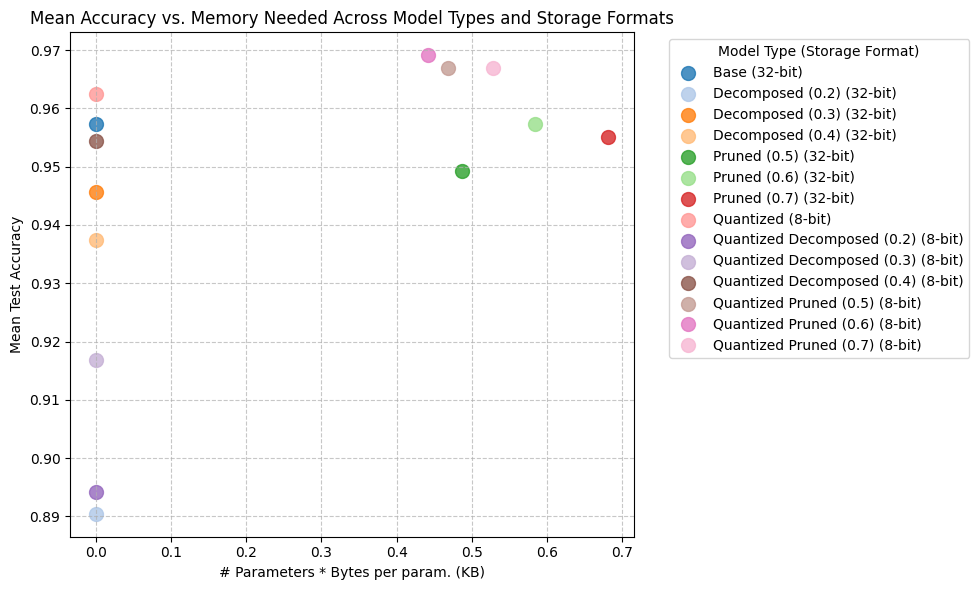

In [155]:
from itertools import cycle

# Define storage format sizes in bytes
storage_formats = {
    '8-bit': 1,   # 1 byte per parameter
    '32-bit': 4   # 4 bytes per parameter
}

# Define a distinct color palette
color_palette = cycle(plt.cm.tab20.colors)  # Use a distinct set of 20 colors

# Parse results for accuracy vs. memory needed
accuracy_vs_storage = []
for key, value in models_dict.items():
    model_name = '_'.join(key.split('_')[:-1])  # Extract model type (e.g., base_model, pruned_model)
    param_count = value['non zero params']
    accuracy = value['test accuracy']
    is_quantized = value['quantized']

    # Determine storage format based on quantization
    storage_format = '8-bit' if is_quantized else '32-bit'
    bytes_per_param = storage_formats[storage_format]
    memory_needed = param_count * bytes_per_param / 1024  # Convert to KB
    memory_needed = value['sparsity']
    accuracy_vs_storage.append({
        'model_name': model_name,
        'accuracy': accuracy,
        'storage_format': storage_format,
        'memory_needed': memory_needed
    })

# Convert to DataFrame for easier handling
df_storage = pd.DataFrame(accuracy_vs_storage)

# Calculate mean for each model and storage format
summary = (
    df_storage
    .groupby(['model_name', 'storage_format'])[['accuracy', 'memory_needed']]
    .mean()
    .reset_index()
)
summary.columns = ['model_name', 'storage_format', 'accuracy_mean', 'memory_mean']

# Assign unique colors to each combination of model_name and storage_format
unique_combinations = summary['model_name'] + ' (' + summary['storage_format'] + ')'
color_mapping = {comb: next(color_palette) for comb in unique_combinations}

# Plot the scatter plot
plt.figure(figsize=(10, 6))
for _, row in summary.iterrows():
    label = f"{row['model_name']} ({row['storage_format']})"
    plt.scatter(
        row['memory_mean'],
        row['accuracy_mean'],
        label=label,
        s=100,
        alpha=0.8,
        color=color_mapping[label]
    )

# Add plot details
plt.title("Mean Accuracy vs. Memory Needed Across Model Types and Storage Formats")
plt.xlabel("# Parameters * Bytes per param. (KB)")
plt.ylabel("Mean Test Accuracy")
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title="Model Type (Storage Format)", loc='best', bbox_to_anchor=(1.05, 1), ncol=1)
plt.tight_layout()
plt.show()


## Results

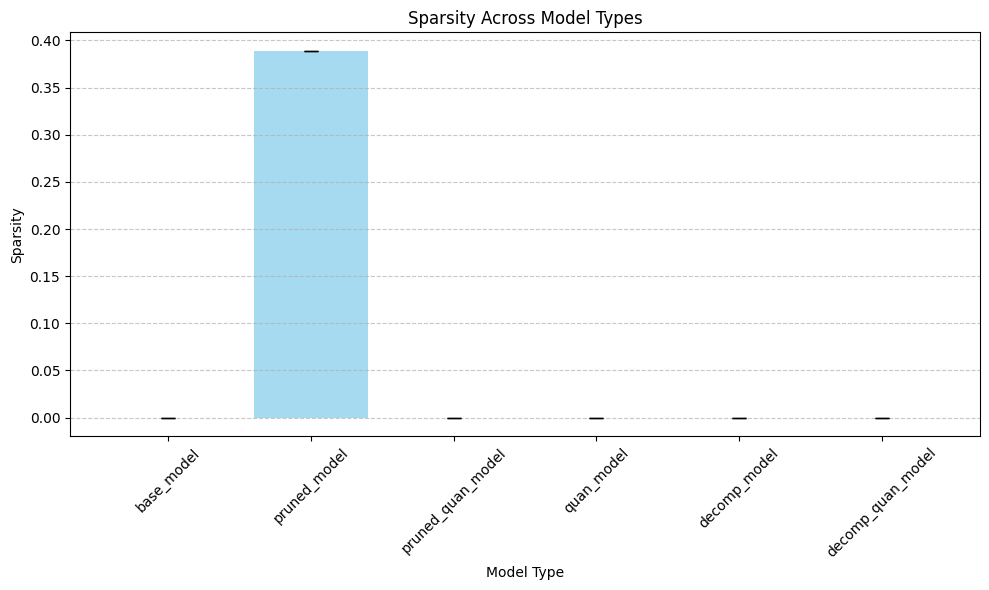

In [40]:

check = 'sparsity'
# check = 'test accuracy'
# check = 'size'
# check = 'sparsity'


if check == 'param count':
    ylabel_name = 'Nunmber of Parameters'
    title_name = 'Number of Parameters Across Model Types'

if check == 'test accuracy':
    ylabel_name = 'Test Accuracy'
    title_name = 'Test Accuracy Across Model Types'

if check == 'size':
    ylabel_name = 'Model Size (KB)'
    title_name = 'Model Size Across Model Types'

if check == 'sparsity':
    ylabel_name = 'Sparsity'
    title_name = 'Sparsity Across Model Types'

# Parse results
results = {}
for key, value in models_dict.items():
    model_name = '_'.join(key.split('_')[:-1])  # Extract model type (e.g., base_model, pruned_model)
    if model_name not in results:
        results[model_name] = []
    results[model_name].append(value[check])

# Calculate mean and standard deviation for each model type
means = {}
std_devs = {}
for model_name, accuracies in results.items():
    means[model_name] = np.mean(accuracies)
    std_devs[model_name] = np.std(accuracies)

# Plot results
model_names = list(means.keys())
mean_values = [means[name] for name in model_names]
std_dev_values = [std_devs[name] for name in model_names]

# Bar plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(model_names, mean_values, yerr=std_dev_values, capsize=5, alpha=0.75, color='skyblue')
plt.xlabel("Model Type")
plt.ylabel(ylabel_name)
plt.title(title_name)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\joris\AppData\Local\Temp\ipykernel_35680\4053890877.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(accuracies, labels=model_names)


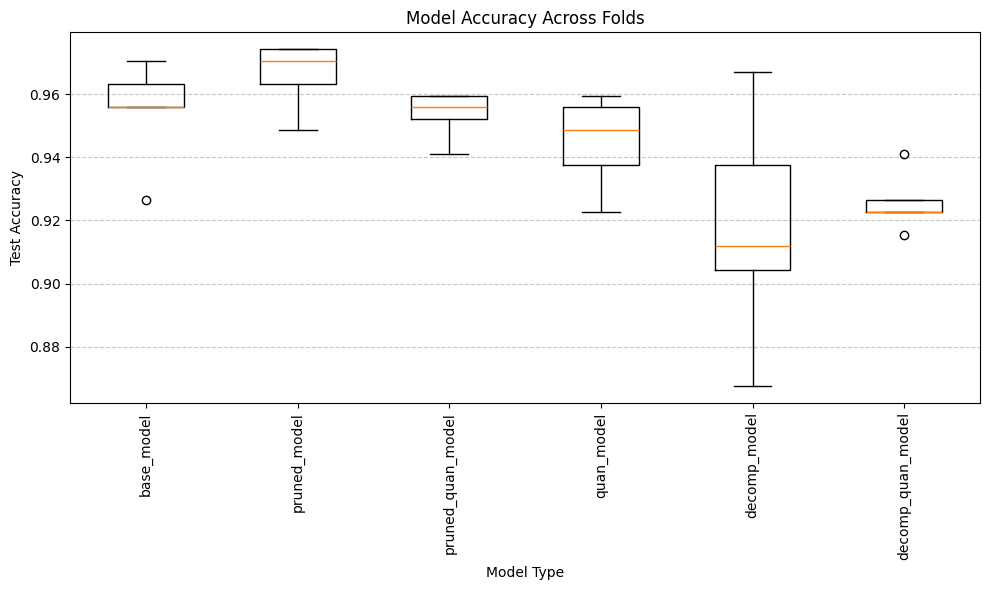

In [48]:
results = {}
for key, value in models_dict.items():
    model_name = '_'.join(key.split('_')[:-1])  # Extract model type (e.g., base_model, pruned_model)
    if model_name not in results:
        results[model_name] = []
    results[model_name].append(value['test accuracy'])

# Prepare data for boxplot
model_names = list(results.keys())
accuracies = [results[model] for model in model_names]

# Create boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(accuracies, labels=model_names)
plt.title("Model Accuracy Across Folds")
plt.xlabel("Model Type")
plt.ylabel("Test Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

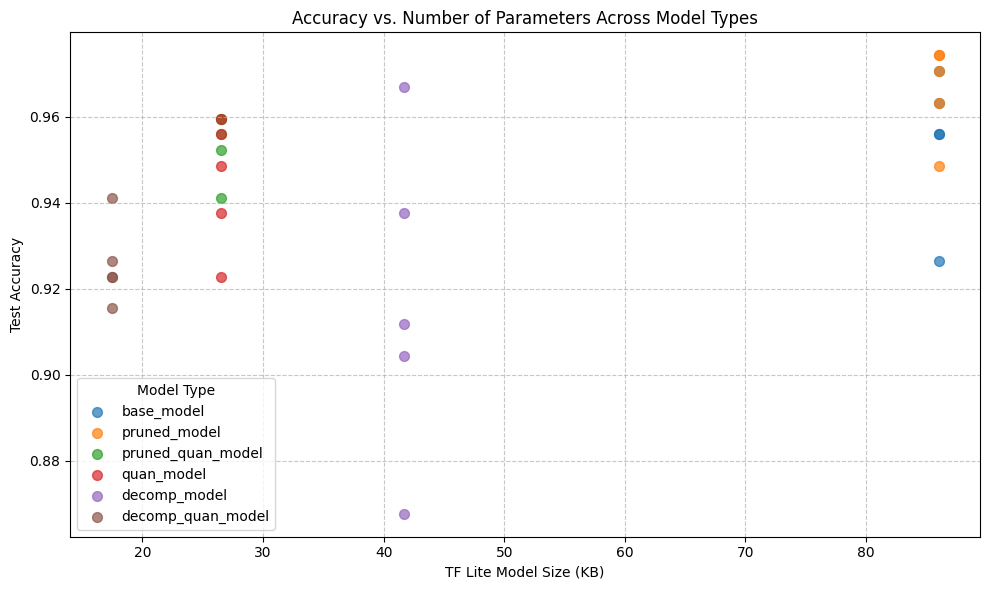

In [64]:
# Parse results for accuracy vs. parameters
accuracy_vs_params = []
for key, value in models_dict.items():
    model_name = '_'.join(key.split('_')[:-1])  # Extract model type (e.g., base_model, pruned_model)
    accuracy_vs_params.append({
        'model_name': model_name,
        'accuracy': value['test accuracy'],
        'param_count': value['size']
    })

# Convert to DataFrame for easier handling
import pandas as pd
df = pd.DataFrame(accuracy_vs_params)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
for model_type in df['model_name'].unique():
    subset = df[df['model_name'] == model_type]
    plt.scatter(subset['param_count'], subset['accuracy'], label=model_type, s=50, alpha=0.7)

# Add plot details
plt.title("Accuracy vs. Number of Parameters Across Model Types")
plt.xlabel("TF Lite Model Size (KB)")
plt.ylabel("Test Accuracy")
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title="Model Type", loc='best')
plt.tight_layout()
plt.show()


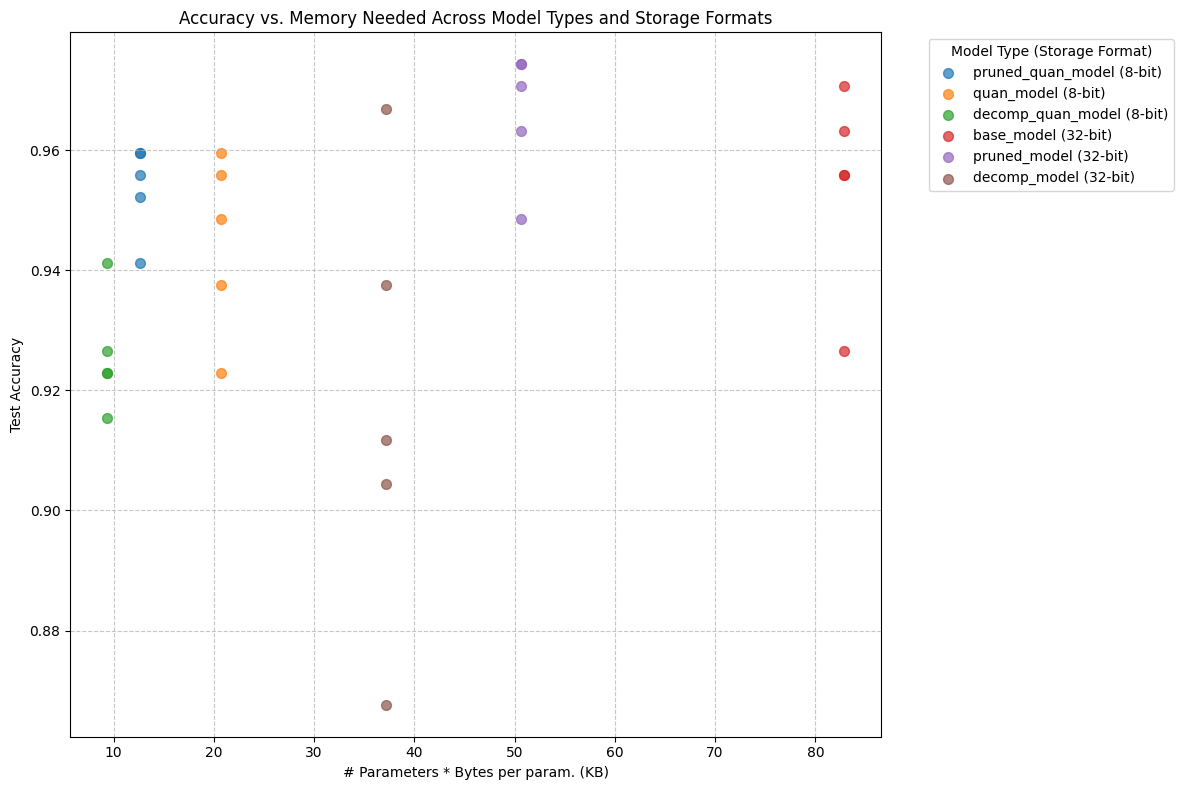

In [63]:
# Define storage format sizes in bytes
storage_formats = {
    '8-bit': 1,   # 1 byte per parameter
    '32-bit': 4   # 4 bytes per parameter
}

# Parse results for accuracy vs. memory needed
accuracy_vs_storage = []
for key, value in models_dict.items():
    model_name = '_'.join(key.split('_')[:-1])  # Extract model type (e.g., base_model, pruned_model)
    param_count = value['param count']
    accuracy = value['test accuracy']
    is_quantized = value['is_quantized']

    # Determine storage format based on quantization
    storage_format = '8-bit' if is_quantized else '32-bit'
    bytes_per_param = storage_formats[storage_format]
    memory_needed = param_count * bytes_per_param / 1024  # Convert to KB

    accuracy_vs_storage.append({
        'model_name': model_name,
        'accuracy': accuracy,
        'storage_format': storage_format,
        'memory_needed': memory_needed
    })

# Convert to DataFrame for easier handling
df_storage = pd.DataFrame(accuracy_vs_storage)

# Plot the scatter plot
plt.figure(figsize=(12, 8))
for storage_format in storage_formats.keys():
    subset = df_storage[df_storage['storage_format'] == storage_format]
    for model_type in subset['model_name'].unique():
        model_subset = subset[subset['model_name'] == model_type]
        plt.scatter(
            model_subset['memory_needed'], 
            model_subset['accuracy'], 
            label=f"{model_type} ({storage_format})", 
            s=50, 
            alpha=0.7
        )

# Add plot details
plt.title("Accuracy vs. Memory Needed Across Model Types and Storage Formats")
plt.xlabel("# Parameters * Bytes per param. (KB)")
plt.ylabel("Test Accuracy")
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title="Model Type (Storage Format)", loc='best', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


#### Other

In [ ]:
# Count pruned weights of stripped model
stripped_model.count_params()

def calculate_sparsity(model):
    total_params = 0
    zero_params = 0

    for layer in model.layers:
        weights = layer.get_weights()
        for w in weights:
            total_params += np.prod(w.shape)
            zero_params += np.sum(w == 0)

    sparsity = zero_params / total_params
    return sparsity

# Example usage
calculate_sparsity(stripped_model)

Total Parameters: 83395
Zero Parameters: 77683
Sparsity: 93.15%


0.9315066850530608

In [135]:
joinkie = models_dict[f'base_model_{1}']['model']

calculate_sparsity(joinkie)

Total Parameters: 83395
Zero Parameters: 77683
Sparsity: 93.15%


0.9315066850530608

### Total


## Transformer

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_embed = tf.keras.layers.Embedding(
            input_dim=max_len,  # Maximum positions we might encode
            output_dim=d_model  # Each position is mapped to a d_model-dimensional vector
        )

    def call(self, x):
        """
        x: A tensor with shape (batch_size, seq_len, d_model)
           - batch_size: number of samples in a batch
           - seq_len: how many time steps in each sample
           - d_model: the Transformer embedding dimension for each time step
        """
        # 1) Extract dynamic shapes from x
        batch_size = tf.shape(x)[0]   # how many sequences in the batch
        seq_len    = tf.shape(x)[1]   # length of each sequence (time steps)
        d_model    = tf.shape(x)[2]   # embedding size at each time step

        # 2) Generate a list of positions [0, 1, 2, ..., seq_len-1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        # positions.shape: (seq_len,)  e.g., (0, 1, 2, ..., seq_len-1)

        # 3) Expand dims so we can replicate these positions across the batch
        # Now positions.shape becomes (1, seq_len)
        positions = tf.expand_dims(positions, axis=0)
        
        # 4) Tile across batch_size to get shape (batch_size, seq_len)
        positions = tf.tile(positions, [batch_size, 1])
        
        # 5) Use self.pos_embed, which is a trainable Embedding layer
        # We pass 'positions' (shape: (batch_size, seq_len)) to get
        # an output of shape (batch_size, seq_len, d_model)
        pos_embeddings = self.pos_embed(positions)

        # 6) Add these position embeddings to the original input x
        # so we “inject” position-specific information into each timestep’s embedding
        return x + pos_embeddings


### Linformer

In [167]:
class LearnablePositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        """
        max_len: Maximum possible sequence length
        d_model: Transformer embedding dimension
        """
        super().__init__()
        self.pos_embed = layers.Embedding(input_dim=max_len, output_dim=d_model)

    def call(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        
        # positions = [0, 1, 2, ..., seq_len - 1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        
        # Expand to shape (batch_size, seq_len) so each sample in the batch has [0..seq_len-1].
        positions = tf.expand_dims(positions, 0)               # shape: (1, seq_len)
        positions = tf.tile(positions, [batch_size, 1])       # shape: (batch_size, seq_len)
        
        # Embed and add
        embedded_positions = self.pos_embed(positions)         # shape: (batch_size, seq_len, d_model)
        return x + embedded_positions

class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout_rate=0.1):
        """
        d_model: Embedding dimension
        num_heads: Number of attention heads
        ff_dim: Hidden dimension in the feed-forward network
        dropout_rate: Dropout probability
        """
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model),
        ])
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x, training):
        # Self-attention (Q=K=V=x for encoder)
        attn_output = self.mha(query=x, value=x, key=x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Residual + LayerNorm
        
        # Feed-forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Residual + LayerNorm
        return out2

class TransformerEncoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, ff_dim, dropout_rate=0.1):
        """
        num_layers: Number of encoder layers to stack
        d_model: Embedding dimension
        num_heads: Number of attention heads
        ff_dim: Hidden dimension of feed-forward network
        dropout_rate: Dropout probability
        """
        super().__init__()
        self.num_layers = num_layers
        self.encoder_layers = [
            TransformerEncoderLayer(d_model, num_heads, ff_dim, dropout_rate)
            for _ in range(num_layers)
        ]
        
    def call(self, x, training):
        for layer in self.encoder_layers:
            x = layer(x, training=training)
        return x

def create_transformer_model(
    seq_len,
    input_dim,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    num_layers=2,
    num_classes=5,
    dropout=0.1
):
    """
    seq_len: Length of the input time series
    input_dim: Number of input features per time step
    d_model: Dimension of the Transformer embeddings
    num_heads: Number of attention heads
    ff_dim: Dimension of the feed-forward layer
    num_layers: Number of stacked transformer layers
    num_classes: Number of output classes
    dropout: Dropout rate
    """
    inputs = keras.Input(shape=(seq_len, input_dim))
    
    # 1) Project input to d_model
    x = layers.Dense(d_model)(inputs)
    
    # 2) Add positional embeddings
    x = LearnablePositionalEncoding(max_len=seq_len, d_model=d_model)(x)
    
    # 3) Transformer Encoder (stack of layers)
    x = TransformerEncoder(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        ff_dim=ff_dim,
        dropout_rate=dropout
    )(x)
    
    # 4) Global average pooling over the time dimension
    x = layers.GlobalAveragePooling1D()(x)
    
    # 5) Classification layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [165]:
print(X_train.shape)

(1088, 10)


In [166]:
# Hyperparameters
seq_len = X_train.shape[0]    # e.g. length of your time series
input_dim = X_train.shape[1]  # e.g. dimension of features in your time series
d_model = 64
num_heads = 4
ff_dim = 128
num_layers = 2
num_classes = np.unique(y_train).shape[0]
dropout_rate = 0.1
learning_rate = 1e-3
batch_size = 32
num_epochs = 10

# Create the model
model = create_transformer_model(
    seq_len=seq_len,
    input_dim=input_dim,
    d_model=d_model,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout_rate
)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Train
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=num_epochs,
    batch_size=batch_size
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Test Accuracy: {test_acc:.4f}")


TypeError: missing a required argument: 'training'